# Packages and plot settings

In [ ]:
import ast
import DA as da
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import stratified_pytorch as sp
import combined_pytorch as cp
import copy
import torch as t
import torch.nn.functional as F
import itertools
import time
import random

import importlib
from tqdm import tqdm
tqdm.pandas()
from scipy.special import softmax
from scipy.stats import weightedtau, entropy
from joblib import Parallel, delayed

import os
import re
import sys
from glob import glob

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style='whitegrid', rc={'grid.alpha': 0.25, 'text.usetex': False})
palette = sns.color_palette('Greys', n_colors=1) + sns.color_palette(n_colors=4)

# Define macros

In [3]:
# If training should only occur on top choice.
TOP_CHOICE_ONLY = False

# Years for training. Options are {'1415', '1516', '1617', '1718', '1819'}.
TRAIN_SET_YEARS = ['1718']
TEST_SET_YEARS = ['1819']

# FEATURES functionality to come...

In [4]:
# Where Avg Color Index and greatschools data lives:
SCHOOL_ATTS_PATH = '../Cleaned Data/schools_rehauled_1718.csv' # (n_schools, d2)

# Where bus route and PTA data lives:
DETAILED_SCHOOL_ATTS_PATH = '../Cleaned Data/SFUSD School Characteristics - School Data.csv' # (n_schools, d1)

# Students x schools individual travel (driving?) times
DISTANCES_PATH = '../Cleaned Data/distances.csv' # (n_students, n_schools)
TRAVEL_TIMES_PATH = '../Cleaned Data/student-all-KG-travel_data-filled.csv' # (n_students, n_schools)
WALK_TIMES_TO_BG_PATH = '../Cleaned Data/bg_to_school_walk_time.csv' # (n_students, n_schools)
MAX_TRAVEL_TIME = 40.

# List of all past data
STUDENT_DATA_PATHS = glob('../Cleaned Data/student_*.csv')

# Data processing functions

In [5]:
# functions that should be somewhere else...
homelang_to_progs = {'CC-Chinese Cantonese': 'CB',
                     'SP-Spanish': 'SB'}
def remove_repeats(entry):
    # if someone voted for the" same candidate twice, it will remove the repeats
    # while still preserving the order of the original list
    if len(list(np.array(entry)[np.sort(np.unique(entry, return_index=True)[1])])) == 0:
        print(entry)
    return list(np.array(entry)[np.sort(np.unique(entry, return_index=True)[1])])

def final_choice(entry):
    return [entry[-1]]

def prep_for_pytorch(ballot, n):
    voters, choices, choice_sets, chosen_sets = ballot['student_id'].values, ballot['choices'].values, ballot['choice_sets'].values, ballot['chosen_sets'].values
    choice_sets_concat, choices_concat, chosen_sets_concat, whose_choice_concat = [], [], [], []
    for idx, choice_set in enumerate(choice_sets):
        assert(len(choice_set)==len(chosen_sets[idx])==len(choices[idx]))
        choice_sets_concat += choice_set
        chosen_sets_concat += chosen_sets[idx]
        choices_concat += choices[idx]
        whose_choice_concat += [voters[idx]]*len(choices[idx])
    
    choices = choices_concat
    choice_set_lengths = np.array([len(choice_set) for choice_set in choice_sets_concat])
    chosen_set_lengths = np.array([len(chosen_set) for chosen_set in chosen_sets_concat])
    x_extra = np.stack([np.array(whose_choice_concat), choice_set_lengths, chosen_set_lengths], axis=1)
    slots_chosen = np.array([choice_set.index(choices[idx]) for idx, choice_set in enumerate(choice_sets_concat)])
    
    kmax = choice_set_lengths.max() #should always be size of universe/greater than max chosen set length
    padded_choice_sets = np.full([len(choice_sets_concat), kmax], fill_value=n, dtype=np.compat.long)
    choice_sets = np.concatenate(choice_sets_concat)
    padded_choice_sets[np.arange(kmax)[None, :] < choice_set_lengths[:, None]] = choice_sets

    padded_chosen_sets = np.full([len(chosen_sets_concat), kmax], fill_value=n, dtype=np.compat.long)
    chosen_sets = np.concatenate(chosen_sets_concat)
    padded_chosen_sets[np.arange(kmax)[None, :] < chosen_set_lengths[:, None]] = chosen_sets
    x = np.stack([padded_choice_sets, padded_chosen_sets], axis=-1)

    return list(map(t.from_numpy, [x, x_extra, slots_chosen]))

def prep_valset(data, program_data, prog_codex):
    restricted_program_lookup = {'CB':[], 'SB':[]}
    codex_programs = copy.deepcopy(prog_codex)
    n=len(codex_programs)
    
    # data['program_id'] = [[codex_programs.index(program) if (program in codex_programs) and (program in program_data.index) else n for program in program_list] 
    #                         if all(np.array([codex_programs.index(program) if (program in codex_programs) and (program in program_data.index) else n for program in program_list])!=n) else None 
    #                         for program_list in data.programs]
    data['program_id'] = [[codex_programs.index(program) for program in program_list] 
                          if all([(program in codex_programs) and (program in program_data.index) for program in program_list]) 
                          else None
                          for program_list in data.programs]
    data = data.dropna(subset=['program_id'])
    all_restricted = []
    for idx, prog in enumerate(codex_programs):
        program_type = program_data.loc[prog, 'program_type']
        if program_type in ['CB', 'SB']:
            all_restricted.append(idx)
            restricted_program_lookup[program_type].append(idx)
    
    cat=pd.Categorical(data['student'])
    data['student_id'] = cat.codes
    codex_student = list(cat.categories)
    codex_ctip = np.zeros(len(codex_student))

    def choice_set_func(entry, univ, language):
        eligibility_list = []
        if language in homelang_to_progs.keys():
            eligibility_list = restricted_program_lookup[homelang_to_progs[language]]
        univ.extend(eligibility_list)
        for item in entry:
            if item not in univ:
                univ.append(item)
        choice_sets = []
        choice_sets.append(list(univ))
        for idx, item in enumerate(entry[1:]):
            univ.remove(entry[idx])
            choice_sets.append(list(univ))
        return choice_sets

    def chosen_set_func(entry):
        chosen_sets = [[]]
        for idx, item in enumerate(entry[1:]):
            chosen_set = chosen_sets[-1].copy()
            chosen_set.extend([entry[idx]])
            chosen_sets.append(chosen_set)
        return chosen_sets

    ballots = []
    for year in data.year.unique():
        year_data = data[data["year"] == year]
        # subset = list(year_data.program_id.explode().unique())
        subset=list(np.arange(len(codex_programs)))
        for item in all_restricted:
            if item in subset:
                subset.remove(item)

        ballot_sort = []
        for ind, item in enumerate(year_data[['program_id', 'ranks']].values):
            if year_data.iloc[ind]['ctip']:
                codex_ctip[year_data.iloc[ind]['student_id']] = 1
            sort_idx = np.argsort(item[1])
            ballot_sort.append([year_data.iloc[ind]['student_id'], 
                                year_data.iloc[ind]['year'], 
                                year_data.iloc[ind]['homelang'], 
                                list(np.array(item[0])[sort_idx]), 
                                list(np.array(item[1])[sort_idx])])
        ballot = pd.DataFrame(ballot_sort, columns = ['student_id', 
                                                      'year',
                                                      'homelang',
                                                      'program_id', 
                                                      'ranks'])
        # print(f"are all ranks sorted? {np.all([np.all(np.array(item) == np.sort(item)) for item in ballot['ranks'].values])}")
        indices_to_remove = np.array([~np.all(np.array(item) == (np.arange(len(item))+1)) for item in ballot['ranks'].values])
        ballot = ballot[~indices_to_remove]
        # print(f"ballots dropped that dont have regular rcv's: {indices_to_remove.sum()}")

        ballot['choices'] = ballot['program_id'].apply(remove_repeats)
#         ballot['choices'] = ballot['program_id'].apply(final_choice)
        ballot['choice_sets'] = ballot.apply(lambda x: choice_set_func(x['choices'], list(subset), language=x['homelang']), axis=1)
        ballot['chosen_sets'] = ballot['program_id'].apply(lambda x: chosen_set_func(x))
        ballots.append(ballot)
    ballot = pd.concat(ballots, ignore_index=True)
    ds = prep_for_pytorch(ballot, n)
    return ds, codex_student, codex_ctip.astype(bool)

def prep_dataset(data, program_data):
    restricted_program_lookup = {'CB':[], 'SB':[]}
    cat=pd.Categorical(data.programs.explode())
    codex_programs = list(cat.categories)
    data['program_id'] = [[codex_programs.index(program) for program in program_list] for program_list in data.programs]
    n=len(codex_programs)

    all_restricted = []
    for idx, prog in enumerate(codex_programs):
        program_type = program_data.loc[prog, 'program_type']
        if program_type in ['CB', 'SB']:
            all_restricted.append(idx)
            restricted_program_lookup[program_type].append(idx)
    
    cat=pd.Categorical(data['student'])
    data['student_id'] = cat.codes
    codex_student = list(cat.categories)
    codex_ctip = np.zeros(len(codex_student))
    
    def choice_set_func(entry, univ, language):
        eligibility_list = []
        if language in homelang_to_progs.keys():
            eligibility_list = restricted_program_lookup[homelang_to_progs[language]]
        univ.extend(eligibility_list)
        for item in entry:
            if item not in univ:
                univ.append(item)
        choice_sets = []
        choice_sets.append(list(univ))
        for idx, item in enumerate(entry[1:]):
            univ.remove(entry[idx])
            choice_sets.append(list(univ))
        return choice_sets

    def chosen_set_func(entry):
        chosen_sets = [[]]
        for idx, item in enumerate(entry[1:]):
            chosen_set = chosen_sets[-1].copy()
            chosen_set.extend([entry[idx]])
            chosen_sets.append(chosen_set)
        return chosen_sets
    
    ballots = []
    for year in data.year.unique():
        year_data = data[data["year"] == year]
        subset = list(year_data.program_id.explode().unique())
        for item in all_restricted:
            if item in subset:
                subset.remove(item)
        ballot_sort = []
        for ind, item in enumerate(year_data[['program_id', 'ranks']].values):
            if year_data.iloc[ind]['ctip']:
                codex_ctip[year_data.iloc[ind]['student_id']] = 1
            sort_idx = np.argsort(item[1])
            ballot_sort.append([year_data.iloc[ind]['student_id'], 
                                year_data.iloc[ind]['year'], 
                                year_data.iloc[ind]['homelang'], 
                                list(np.array(item[0])[sort_idx]), 
                                list(np.array(item[1])[sort_idx])])
        ballot = pd.DataFrame(ballot_sort, columns = ['student_id', 
                                                      'year',
                                                      'homelang',
                                                      'program_id', 
                                                      'ranks'])
        # print(f"are all ranks sorted? {np.all([np.all(np.array(item) == np.sort(item)) for item in ballot['ranks'].values])}")
        indices_to_remove = np.array([~np.all(np.array(item) == (np.arange(len(item))+1)) for item in ballot['ranks'].values])
        ballot = ballot[~indices_to_remove]
        # print(f"ballots dropped that dont have regular rcv's: {indices_to_remove.sum()}")

        ballot['choices'] = ballot['program_id'].apply(remove_repeats)
        ballot['choice_sets'] = ballot.apply(lambda x: choice_set_func(x['choices'], list(subset), language=x['homelang']), axis=1)
        # ballot['choices_ind'] = [[choice_set.index(choice) for choice, choice_set in zip(choices, choice_sets)] for choices, choice_sets in zip(ballot['choices'], ballot['choice_sets'])]
        ballot['chosen_sets'] = ballot['choices'].apply(lambda x: chosen_set_func(x))
        ballots.append(ballot)
    ballot = pd.concat(ballots, ignore_index=True)
    ds = prep_for_pytorch(ballot, n)

    return ds, codex_student, codex_programs, codex_ctip.astype(bool), ballot

# Load school attributes

In [6]:
detailed_school_attributes = pd.read_csv(DETAILED_SCHOOL_ATTS_PATH, index_col="School Code")

In [7]:
detailed_school_attributes['Avg_Trust_Fund'] = [float(re.sub(r'[^\d.]', '', amount)) for amount in detailed_school_attributes['Avg Trust Fund (2019 to 2022)']]
detailed_school_attributes['PTA_Funds_Per_Pupil'] = [float(re.sub(r'[^\d.]', '', amount)) for amount in detailed_school_attributes['Annual PTA funds per pupil']]
detailed_school_attributes['School bus from'] = detailed_school_attributes['School bus from'].fillna('[]')
detailed_school_attributes['School bus from K'] = detailed_school_attributes['School bus from']

In [8]:
# Manual fixes and entries
detailed_school_attributes.loc[796, 'School bus from K'] = '94110, 94124, 94134'
detailed_school_attributes.loc[479, 'School bus from K'] = '94102, 94115, 94124'
detailed_school_attributes.loc[876, 'Has Before School Programs'] = 'No'
detailed_school_attributes.loc[876, 'Has After School Programs'] = 'Yes'

In [9]:
detailed_school_attributes['School bus from K'] = detailed_school_attributes['School bus from K'].apply(lambda x: ast.literal_eval(x))

In [10]:
school_attributes = pd.read_csv(SCHOOL_ATTS_PATH, index_col='school_id')

In [11]:
# Manual entries
# from California Assessment of Student Performance and Progress for 1718 sy
# https://caaspp-elpac.cde.ca.gov/caaspp/ViewReport?ps=true&lstTestYear=2019&lstTestType=B&lstGroup=1&lstGrade=13&lstSchoolType=A&lstCounty=38&lstDistrict=68478&lstSchool=6104673
school_attributes.loc[476, 'math_scores_1819'] = np.mean([2337.8, 2393.9, 2397.7])
school_attributes.loc[476, 'eng_scores_1819'] = np.mean([2337.8, 2393.9, 2397.7])
school_attributes.loc[507, 'math_scores_1819'] = np.mean([2346.1, 2408.2, 2407.7])
school_attributes.loc[507, 'eng_scores_1819'] = np.mean([2332.8, 2411.4, 2392.1])
school_attributes.loc[537, 'math_scores_1819'] = np.mean([2362.8, 2401.8, 2453.5])
school_attributes.loc[537, 'eng_scores_1819'] = np.mean([2369.1, 2413.7, 2468.5])
# school_attributes = school_attributes.drop([476])

In [12]:
school_attributes['avg_scores_1819'] = school_attributes[['eng_scores_1819', 'math_scores_1819']].mean(axis=1)
school_attributes['avg_scores_1819'] = school_attributes['avg_scores_1819'].subtract(school_attributes['avg_scores_1819'].min())\
                                            .divide(school_attributes['avg_scores_1819'].max() - school_attributes['avg_scores_1819'].min())
for column in ['ela_color', 'math_color', 'chronic_color', 'suspension_color']:
    school_attributes[column].replace(['Red', 'Orange', 'Yellow', 'Green', 'Blue'], [1.,2.,3.,4.,5.], inplace=True)
school_attributes['AvgColorIndex'] = school_attributes[['ela_color', 'math_color', 'chronic_color', 'suspension_color']].mean(numeric_only=True, axis=1)
school_attributes['% FRL 2019-2022'] = detailed_school_attributes.loc[school_attributes.index,'% FRL']
school_attributes['PTA funds per pupil'] = detailed_school_attributes.loc[school_attributes.index,'PTA_Funds_Per_Pupil']
school_attributes['has_before_school_progs'] = detailed_school_attributes.loc[school_attributes.index,'Has Before School Programs'].map({'Yes':1, 'No':0})
school_attributes['has_after_school_progs'] = detailed_school_attributes.loc[school_attributes.index,'Has After School Programs'].map({'Yes':1, 'No':0})

/tmp/ipykernel_3357181/3593837362.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)


Text(0.5, 1.0, 'School feature correlations')

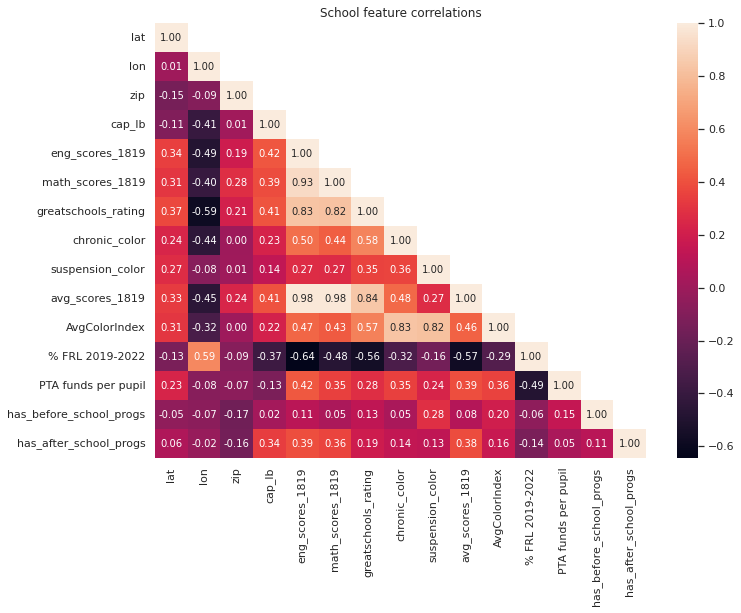

In [13]:
fig,ax=plt.subplots(1,1, figsize=(11,8))
corr_matrix = school_attributes.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, False)
sns.heatmap(corr_matrix, 
            mask=mask, 
            annot=True,
            fmt='.2f',
            ax=ax)
plt.title('School feature correlations')

In [14]:
prog_to_nest = {'GE': 'General Education', 
                'MM': 'Special Education', #Mild-Moderate
                'MS': 'Special Education', #Moderate-Severe
                'SA': 'Special Education', 
                'AF': 'Special Education', 
                'ED': 'Special Education', 
                'DA': 'Special Education', 
                'DT': 'Special Education',
                'SN': 'Spanish Language',
                'SE': 'Spanish Language', 
                'NS': 'Spanish Language',
                'SB': 'Spanish Language',
                'CE': 'Chinese Language',
                'CN': 'Chinese Language',
                'ME': 'Chinese Language',
                'MN': 'Chinese Language',
                'CT': 'Chinese Language',
                'NC': 'Chinese Language',
                'CB': 'Chinese Language',
                'JN': 'Japanese Language',
                'JB': 'Japanese Language',
                'JE': 'Japanese Language', 
                'KE': 'Korean Language',
                'KN': 'Korean Language',
                'FB': 'Filipino Language'}

In [15]:
program_attributes = pd.read_csv('../Cleaned Data/programs_1718.csv', index_col='program_id')
program_attributes['school_id'] = program_attributes.school_id.astype(int)
program_attributes['nest_membership'] = [prog_to_nest[program_type] for program_type in program_attributes['program_type']]
# program_attributes['greatschools_rating'] = [school_attributes.loc[school,'greatschools_rating'] for school in program_attributes.school_id]
program_attributes['AvgColorIndex'] = [school_attributes.loc[school,'AvgColorIndex'] for school in program_attributes.school_id]
# program_attributes['AvgColorIndex_scaled'] = program_attributes['AvgColorIndex']/5.
# program_attributes['AvgColorIndex_normed'] = program_attributes['AvgColorIndex'].subtract(program_attributes['AvgColorIndex'].min())\
#                                 .divide(program_attributes['AvgColorIndex'].max() - program_attributes['AvgColorIndex'].min())
# program_attributes['zip'] = [school_attributes.loc[school,'zip'] for school in program_attributes.school_id]
# program_attributes['lat'] = [school_attributes.loc[school,'lat'] for school in program_attributes.school_id]
# program_attributes['lon'] = [school_attributes.loc[school,'lon'] for school in program_attributes.school_id]
program_attributes['portion_FRL'] = [school_attributes.loc[school,'% FRL 2019-2022']/100. for school in program_attributes.school_id]
# program_attributes['pta_funds'] = [school_attributes.loc[school,'PTA funds per pupil'] for school in program_attributes.school_id]
# program_attributes['pta_funds_normed'] = program_attributes['pta_funds'].subtract(program_attributes['pta_funds'].min())\
#                                 .divide(program_attributes['pta_funds'].max() - program_attributes['pta_funds'].min())
program_attributes['has_before_school_progs'] = [school_attributes.loc[school,'has_before_school_progs'] for school in program_attributes.school_id]
program_attributes['has_after_school_progs'] = [school_attributes.loc[school,'has_after_school_progs'] for school in program_attributes.school_id]
program_attributes.head()

,Unnamed: 0,school_id,program_type,capacity,r2_capacity,r3_capacity,r1_assigned,r1_noenroll,r1_first_choice,nest_membership,AvgColorIndex,portion_FRL,has_before_school_progs,has_after_school_progs
program_id,,,,,,,,,,,,,,
413-GE-KG,0,413,GE,88,92,88,88.0,18.0,89.0,General Education,3.5,0.367206,0,1
413-SA-KG,1,413,SA,2,2,2,1.0,0.0,1.0,Special Education,3.5,0.367206,0,1
420-GE-KG,2,420,GE,44,44,42,44.0,16.0,44.0,General Education,3.5,0.295983,1,1
420-MS-KG,3,420,MS,4,4,4,3.0,0.0,3.0,Special Education,3.5,0.295983,1,1
420-SE-KG,4,420,SE,18,18,18,18.0,3.0,69.0,Spanish Language,3.5,0.295983,1,1


In [16]:
cat=pd.Categorical(program_attributes['nest_membership'])
nests = list(cat.categories)
program_attributes['nest_id'] = cat.codes

# Load travel data

In [17]:
distances = pd.read_csv(DISTANCES_PATH,index_col=0)
distances.columns = distances.columns.astype(int)
sqrt_distances = np.sqrt(distances)

In [18]:
program_sqrt_distances = sqrt_distances.loc[distances.index, program_attributes.school_id]
program_sqrt_distances.columns = program_attributes.index

In [19]:
bg_to_school_walktime = pd.read_csv(WALK_TIMES_TO_BG_PATH, index_col='origin_bg')
bg_to_school_walktime.columns = bg_to_school_walktime.columns.astype(int)

Helper dict for language-related covariate later:

In [20]:
lang_to_program = {'CC-Chinese Cantonese': ['CB','CE','CN','CT', 'NC'],
                   'SP-Spanish': ['SB','SE','SN','NS'],
                   'CM-Chinese Mandarin': ['ME','MN'],
                   'JA-Japanese': ['JE','JN'],
                   'KO-Korean': ['KE','KN'],
                   'FT-Filipino Tagalog': ['FB'],
                   'FI-Filipino Ilocano': ['FB']}

In [21]:
program_to_language = {item: k for k, v in lang_to_program.items() for item in v}

# Load preference data

In agreement with EdData: https://www.ed-data.org/article/Ethnic-Diversity-Index#:~:text=Diversity%20Index%20calculated%3F-,What%20is%20the%20Ethnic%20Diversity%20Index%3F,groups%20in%20its%20student%20population.

In [22]:
def aggregate_ethnicities(row):
    if row['resolved_ethnicity'] in ['Decline to State']:
        return 'Decline to State'
    elif row['resolved_ethnicity'] in ['Black or African American']:
        return 'Black or African American'
    elif row['resolved_ethnicity'] in ['American Indian or Alaskan Native']:
        return 'American Indian or Alaskan Native'
    elif row['resolved_ethnicity'] in ['Asian', 'Asian Indian', 'Chinese', 'Korean', 'Vietnamese', 'Cambodian', 'Japanese', 'Other Asian']:
        return 'Asian'
    elif row['resolved_ethnicity'] in ['Hispanic/Latino']:
        return 'Hispanic/Latino'
    elif row['resolved_ethnicity'] in ['Filipino']:
        return 'Filipino'
    elif row['resolved_ethnicity'] in ['Pacific Islander', 'Other Pacific Islander', 'Samoan']:
        return 'Pacific Islander'
    elif row['resolved_ethnicity'] in ['White', 'Middle Eastern/Arabic']:
        return 'White'
    elif row['resolved_ethnicity'] in ['Two or More Races']:
        return 'Two or More Races'

In [24]:
years = [''.join(re.findall(r'\d+', path)) for path in STUDENT_DATA_PATHS]
STUDENT_DATA_PATHS, years

(['../Cleaned Data/student_1718.csv',
  '../Cleaned Data/student_1819.csv',
  '../Cleaned Data/student_1516.csv',
  '../Cleaned Data/student_1617.csv',
  '../Cleaned Data/student_1415.csv'],
 ['1718', '1819', '1516', '1617', '1415'])

In [23]:
# raw_data = pd.read_csv(STUDENT_DATA_PATHS[0])
# raw_data['year'] = years[0]
data1 = pd.read_csv('../Cleaned Data/student_1718.csv')
data1['year'] = '1718'
data2 = pd.read_csv('../Cleaned Data/student_1819.csv')
data2['year'] = '1819'
raw_data = pd.concat([data1, data2], ignore_index=True, sort=False)

/tmp/ipykernel_3357181/3852517074.py:3: DtypeWarning: Columns (2,3,4,6,11,12,13,14,15,16,17,18,71,74) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv('../Cleaned Data/student_1718.csv')
/tmp/ipykernel_3357181/3852517074.py:5: DtypeWarning: Columns (2,3,4,6,11,12,13,14,58) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv('../Cleaned Data/student_1819.csv')


In [36]:
df = raw_data[raw_data.grade=='KG'].dropna(subset=['studentno'])
df = df[df.census_blockgroup.isin(bg_to_school_walktime.index)]
df['first_participated_round'] = (~df[['r1_programs', 'r2_programs', 'r3_programs', 'r5_programs']].isna()).apply(lambda x: np.where(x)[0][0]+1, axis=1)
                                       # , 'r4_programs'
df['first_participated_round'] = [roundd if roundd!= 4 else 5 for roundd in df['first_participated_round']]                                      
for col in ['r1_ranked_idschool', 'r2_ranked_idschool', 'r3_ranked_idschool', 'r5_ranked_idschool',
            # 'r4_ranked_idschool', 
            'r1_programs', 'r2_programs', 'r3_programs', 'r5_programs',
            # 'r4_programs',  
            'r1_listed_ranks', 'r2_listed_ranks', 'r3_listed_ranks', 'r5_listed_ranks',
            # 'r4_listed_ranks', 
            'sibling', 'aaprek', 'aa']:
    df[col] = df[col].fillna(value='[]').apply(lambda x: ast.literal_eval(x))
df['idschoolattendance'] = df['idschoolattendance'].apply(lambda x: int(x))
df['freelunch_prob_group'] = pd.qcut(df['freelunch_prob'],
                                q=[0, 1/2, 1],
                                labels=['low', 'high']) 
df['r1_ranked_programs'] = [[str(school)+'-'+str(program)+'-KG' for school, program in zip(ranked_list, programs)] for ranked_list, programs in zip(df['r1_ranked_idschool'], df['r1_programs'])]
df['r2_ranked_programs'] = [[str(school)+'-'+str(program)+'-KG' for school, program in zip(ranked_list, programs)] for ranked_list, programs in zip(df['r2_ranked_idschool'], df['r2_programs'])]
df['r3_ranked_programs'] = [[str(school)+'-'+str(program)+'-KG' for school, program in zip(ranked_list, programs)] for ranked_list, programs in zip(df['r3_ranked_idschool'], df['r3_programs'])]
# df['r4_ranked_programs'] = [[str(school)+'-'+str(program)+'-KG' for school, program in zip(ranked_list, programs)] for ranked_list, programs in zip(df['r4_ranked_idschool'], df['r4_programs'])]
df['r5_ranked_programs'] = [[str(school)+'-'+str(program)+'-KG' for school, program in zip(ranked_list, programs)] for ranked_list, programs in zip(df['r5_ranked_idschool'], df['r5_programs'])]
df['first_ranked_programs'] = [row['r'+str(row['first_participated_round'])+'_ranked_programs'] for _, row in df.iterrows()]

In [37]:
df['normed_ethnicity'] = df.apply(aggregate_ethnicities, axis=1)

# Repeated selection

In [38]:
def clean_dataframe(df, program_covariates):
    data_list = []
    for i, row in df.iterrows():
        student = row['studentno']
        first_round = str(row['first_participated_round'])
        if TOP_CHOICE_ONLY:
            program = row['r'+first_round+'_ranked_programs'][0]
            rank = row['r'+first_round+'_listed_ranks'][0]
            programs = [program]
            ranks = [rank]
        else:
            programs = row['r'+first_round+'_ranked_programs']
            ranks = row['r'+first_round+'_listed_ranks']
        ctip = row['ctip1']
        homelang = row['homelang_desc']
        year = row['year']
        num_ranked = len(programs)
        if student in program_sqrt_distances.index and all([program in program_covariates.index and program in program_sqrt_distances.columns for program in programs]):
            data_list.append([student, programs, num_ranked, ranks, year, ctip, homelang])
    dataset = pd.DataFrame(data_list, columns = ['student', 'programs', 'num_ranked', 'ranks', 'year', 'ctip', 'homelang'])
    return dataset

In [39]:
# Choices: [x, x_extra, slots_chosen] where
# x = np.stack([padded_choice_sets, padded_chosen_sets], axis=-1)
# x_extra = np.stack([np.array(whose_choice_concat), choice_set_lengths, chosen_set_lengths], axis=1)

dff = df[df.year.isin(TRAIN_SET_YEARS)]
dataset = clean_dataframe(dff, program_attributes)
choices, student_codex, program_codex, ctip_codex, ballot = prep_dataset(dataset, program_attributes)

In [40]:
school_codex=list(program_attributes.loc[program_codex,'school_id'].values)
assert(len(school_codex)==len(program_codex))

In [41]:
num_programs = len(program_codex)
num_students = len(student_codex)
print('No. students: ', num_students)
print('No. programs: ', num_programs)
print('Avg. len of ranking', dataset.num_ranked.mean())
print('No. training examples', choices[0].shape[0])
print('% CTIP1', ctip_codex.mean())

No. students:  5019
No. programs:  154
Avg. len of ranking 9.903367204622434
No. training examples 48714
% CTIP1 0.16676628810520025


# Covariates

The following cell creates a number of (num_students, num_programs) matrices, which will all be stacked depth-wise to form $X$

In [42]:
busroutes_lookup = pd.DataFrame(0, index = df.zipcode.unique(), columns=program_sqrt_distances.columns)
for program in program_attributes.index:
    school = program_attributes.loc[program, 'school_id']
    zip_list = detailed_school_attributes.loc[school, 'School bus from K']
    busroutes_lookup.loc[zip_list, program] = 1

In [43]:
bg_to_prog_walktime = bg_to_school_walktime.loc[bg_to_school_walktime.index, program_attributes.school_id]
bg_to_prog_walktime.columns = program_attributes.index
bg_to_prog_walktime.head(2)

program_id,413-GE-KG,413-SA-KG,420-GE-KG,420-MS-KG,420-SE-KG,420-SN-KG,435-GE-KG,456-GE-KG,456-SB-KG,618-MM-KG,618-SE-KG,618-SN-KG,449-FB-KG,449-GE-KG,625-GE-KG,476-NC-KG,603-DT-KG,603-GE-KG,603-SB-KG,872-CB-KG,872-GE-KG,509-CE-KG,509-CN-KG,478-GE-KG,478-JB-KG,478-MM-KG,481-GE-KG,481-SB-KG,525-GE-KG,507-GE-KG,521-GE-KG,537-MS-KG,537-SE-KG,537-SN-KG,539-ED-KG,539-GE-KG,680-ED-KG,680-GE-KG,680-SE-KG,680-SN-KG,562-CE-KG,562-CN-KG,562-GE-KG,575-GE-KG,575-SA-KG,575-SB-KG,589-GE-KG,589-SA-KG,593-GE-KG,593-SB-KG,453-GE-KG,453-SE-KG,453-SN-KG,614-CB-KG,614-GE-KG,614-MM-KG,614-SB-KG,644-AF-KG,644-GE-KG,544-GE-KG,544-MM-KG,544-MS-KG,838-GE-KG,838-ME-KG,838-MN-KG,838-SA-KG,664-DA-KG,664-GE-KG,670-AF-KG,670-GE-KG,490-CB-KG,490-GE-KG,676-GE-KG,676-MS-KG,479-GE-KG,479-KE-KG,479-KN-KG,691-FB-KG,691-GE-KG,691-MM-KG,691-SB-KG,830-GE-KG,714-SE-KG,714-SN-KG,549-GE-KG,718-GE-KG,724-NS-KG,505-GE-KG,722-AF-KG,722-GE-KG,729-CB-KG,729-GE-KG,729-SE-KG,729-SN-KG,814-GE-KG,723-CB-KG,723-GE-KG,723-SB-KG,650-GE-KG,650-SB-KG,735-GE-KG,746-GE-KG,746-ME-KG,746-MN-KG,638-CB-KG,638-GE-KG,786-GE-KG,786-JB-KG,786-MM-KG,760-GE-KG,760-MM-KG,760-SE-KG,760-SN-KG,569-GE-KG,569-MM-KG,790-GE-KG,796-GE-KG,816-GE-KG,816-MS-KG,816-SB-KG,656-GE-KG,656-SB-KG,493-GE-KG,820-GE-KG,823-AF-KG,823-GE-KG,488-GE-KG,834-CB-KG,834-GE-KG,834-SB-KG,782-GE-KG,782-MM-KG,842-GE-KG,842-MS-KG,750-GE-KG,750-SA-KG,848-CB-KG,848-GE-KG,513-CB-KG,513-ED-KG,513-GE-KG,513-SB-KG,859-ED-KG,859-GE-KG,862-CB-KG,862-GE-KG,867-CB-KG,867-GE-KG,497-GE-KG,497-SE-KG,497-SN-KG,876-CE-KG,876-CN-KG,876-GE-KG,801-GE-KG,801-SA-KG,485-CE-KG,485-CT-KG
origin_bg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6.075010e+10,103.181533,103.181533,92.355933,92.355933,92.355933,92.355933,106.858933,87.275667,87.275667,82.985133,82.985133,82.985133,47.318400,47.318400,117.402800,21.454600,78.333933,78.333933,78.333933,18.656800,18.656800,82.1462,82.1462,105.648333,105.648333,105.648333,132.182533,132.182533,53.231933,117.718800,143.513933,102.837133,102.837133,102.837133,152.342933,152.342933,89.295933,89.295933,89.295933,89.295933,10.475067,10.475067,10.475067,120.823333,120.823333,120.823333,93.975133,93.975133,150.669933,150.669933,139.078800,139.078800,139.078800,124.516133,124.516133,124.516133,124.516133,115.823733,115.823733,148.7088,148.7088,148.7088,86.144267,86.144267,86.144267,86.144267,124.688733,124.688733,160.281533,160.281533,21.479000,21.479000,138.437933,138.437933,71.079133,71.079133,71.079133,152.140333,152.140333,152.140333,152.140333,113.851400,62.275333,62.275333,96.097733,75.486333,105.261133,81.327933,127.563933,127.563933,126.570533,126.570533,126.570533,126.570533,38.033733,78.333933,78.333933,78.333933,59.237733,59.237733,82.243267,165.358933,165.358933,165.358933,15.131267,15.131267,51.533933,51.533933,51.533933,110.273600,110.273600,110.273600,110.273600,85.060133,85.060133,33.027933,90.902733,72.603533,72.603533,72.603533,106.750533,106.750533,126.570533,159.184133,26.562333,26.562333,143.552133,25.998933,25.998933,25.998933,155.247733,155.247733,136.087933,136.087933,160.0688,160.0688,87.466333,87.466333,126.510467,126.510467,126.510467,126.510467,44.426533,44.426533,168.625333,168.625333,148.458267,148.458267,74.362267,74.362267,74.362267,130.428933,130.428933,130.428933,11.6044,11.6044,118.252933,118.252933
6.075010e+10,101.583600,101.583600,90.122400,90.122400,90.122400,90.122400,105.261000,84.842067,84.842067,80.751600,80.751600,80.751600,44.837333,44.837333,114.084533,17.807467,76.100400,76.100400,76.100400,14.454333,14.454333,79.9232,79.9232,103.414800,103.414800,103.414800,129.949000,129.949000,51.634000,114.400533,141.280400,100.603600,100.603600,100.603600,150.109400,150.109400,87.062400,87.062400,87.062400,87.062400,6.000800,6.000800,6.000800,118.589800,118.589800,118.589800,91.741600,91.741600,148.436400,148.436400,135.760533,135.760533,135.760533,122.282600,122.282600,12

In [44]:
busroutes = pd.DataFrame(0, columns=program_sqrt_distances.columns, index=program_sqrt_distances.index)
walking_time = pd.DataFrame(0, columns=program_sqrt_distances.columns, index=program_sqrt_distances.index)
siblings = pd.DataFrame(0, columns=program_sqrt_distances.columns, index=program_sqrt_distances.index)
aaprek = pd.DataFrame(0, columns=program_sqrt_distances.columns, index=program_sqrt_distances.index)
aa = pd.DataFrame(0, columns=program_sqrt_distances.columns, index=program_sqrt_distances.index)
langprograms = pd.DataFrame(0, columns=program_sqrt_distances.columns, index=program_sqrt_distances.index)
# langprograms.loc[:,program_attributes[program_attributes.program_type=='GE'].index] = 1
for i, row in df.iterrows():
    student = row['studentno']
    if student not in program_sqrt_distances.index:
        continue
    zipcode = row.loc['zipcode']
    lang = row.loc['homelang_desc']
    bg = row.loc['census_blockgroup']
    sibling_list = row.loc['sibling']
    prek = row.loc['aaprek']
    aa_school = row.loc['idschoolattendance']
    busroutes.loc[student, :] = busroutes_lookup.loc[zipcode,:]

    walking_time.loc[student, :] = bg_to_prog_walktime.loc[bg,:].astype(int)

    program_series = program_attributes[program_attributes.school_id==aa_school].index
    aa.loc[student, program_series] += 1

    program_series = program_attributes[program_attributes.school_id.isin(prek)].index
    aaprek.loc[student, program_series] += 1

    program_series = program_attributes[program_attributes.school_id.isin(sibling_list)].index
    siblings.loc[student, program_series] += 1

    if (lang in ['CC-Chinese Cantonese', 'SP-Spanish', 'CM-Chinese Mandarin', 'JA-Japanese', 'KO-Korean', 'FT-Filipino Tagalog', 'FI-Filipino Ilocano']):
        program_series = program_attributes[program_attributes.program_type.isin(lang_to_program[lang])].index
        langprograms.loc[student, program_series] += 1

Selecting the relevant students and programs of each:

In [45]:
def generate_covariate_matrix(program_attributes, student_codex, program_codex, ctip_codex):
    n=len(program_codex)
    
    # School/program atts
    avg_color = np.array(program_attributes.loc[program_codex, 'AvgColorIndex']).reshape(1,n)
    before_after_school = np.array(program_attributes.loc[program_codex, 'has_after_school_progs']|program_attributes.loc[program_codex, 'has_before_school_progs']).reshape(1,n)
    frl = np.array(program_attributes.loc[program_codex, 'portion_FRL']).reshape(1,n)

    # Student/program atts
    avg_color_nonCTIP = np.multiply((~ctip_codex)[:,None], avg_color)[:,:,None]
    avg_color_CTIP = np.multiply((ctip_codex)[:,None], avg_color)[:,:,None]
    frl_nonCTIP = np.multiply((~ctip_codex)[:,None], frl)[:,:,None]
    frl_CTIP = np.multiply((ctip_codex)[:,None], frl)[:,:,None]
    beforeafter_nonCTIP = np.multiply((~ctip_codex)[:,None], before_after_school)[:,:,None]
    beforeafter_CTIP = np.multiply((ctip_codex)[:,None], before_after_school)[:,:,None]
    sqrt_program_distances = np.array(program_sqrt_distances.loc[student_codex, program_codex])[:,:,None]
    # sqrt_travel_times = np.array(program_sqrt_travel_times.loc[student_codex, program_codex])[:,:,None]
    bus_route = np.array(busroutes.loc[student_codex, program_codex])[:,:,None]
    within_15min_walk = np.array(walking_time.loc[student_codex, program_codex]<=15.)[:,:,None]
    sibling_match = np.array(siblings.loc[student_codex, program_codex])[:,:,None]
    aaprek_match = np.array(aaprek.loc[student_codex, program_codex])[:,:,None]
    aa_match = np.array(aa.loc[student_codex, program_codex])[:,:,None]
    language_match = np.array(langprograms.loc[student_codex, program_codex])[:,:,None]
    return np.dstack([avg_color_nonCTIP,
                      avg_color_CTIP,
                      frl_nonCTIP,
                      frl_CTIP,
                      beforeafter_nonCTIP,
                      beforeafter_CTIP,
                      sqrt_program_distances,
                      within_15min_walk,
                      bus_route,
                      sibling_match,
                      language_match,
                      aa_match,
                      aaprek_match]).astype(np.float32)

Stacking into covariate array, X

In [46]:
covariate_names = ['Avg. Color, non-CTIP', 'Avg. Color, CTIP', 
                   'FRL, non-CTIP', 'FRL, CTIP', 
                   'Before/after school prog, non-CTIP', 'Before/after school prog, CTIP',
                   'Sqrt. distance', 'Within 15 min walk', 
                   'Exists bus route', 'Sib. Match', 'Lang. Match', 
                   'AA', 'PreK/TK']

# Hyperparameter tuning

In [47]:
def compute_null_loss(x, x_extra, y, num_ranks=5):
    batch_size, seq_len, _ = x.size()
    y_hat = F.log_softmax(t.zeros((batch_size, seq_len, 1)), 1)
    terms = []
    for i in range(num_ranks):
        rows = x_extra[:,2]==i
        terms.append(F.nll_loss(y_hat[rows], y[rows, None].long()).detach().numpy())
    return (F.nll_loss(y_hat, y[:, None].long()), terms)

In [48]:
'''
Generate k-folds, stratified by CTIP status.
'''
kfolds=5
shuffled = dataset.sample(frac=1).reset_index(drop=True)
folds = np.array_split(shuffled, kfolds)

## Sweep over local regularization

In [66]:
importlib.reload(sp)

<module 'stratified_pytorch' from '/home/ameloa/school_choice_project/arjun_cdm/stratified_pytorch.py'>

In [67]:
def reg_sweep(i, wd, model_name, fixed_effect, linear, context):
    result=[]
    val = folds[i]
    train = pd.concat([df for j, df in enumerate(folds) if j!=i])
    train_choices, train_st_codex, train_prog_codex, train_ctip_codex, train_ballot = prep_dataset(train, program_attributes)
    (xval, xlval, yval), val_st_codex, val_ctip_codex = prep_valset(val, program_attributes, train_prog_codex)
    X_train = generate_covariate_matrix(program_attributes, train_st_codex, train_prog_codex, train_ctip_codex)
    X_val = generate_covariate_matrix(program_attributes, val_st_codex, train_prog_codex, val_ctip_codex)

    '''
    Train and validate models
    '''
    if model_name=='nested':
        nest_memberships = program_attributes.loc[train_prog_codex,'nest_id'].values
        kwargs={'fixed_effects': True,
                'linear_terms': True,
                'covariates': X_train,
                'num_nests': len(nests),
                'nest_memberships': nest_memberships}
        model, tr_loss, num_epochs, tr_losses, _ = sp.train_stratified(ds=train_choices, 
                                                                       num_items=len(train_prog_codex), 
                                                                       epochs=1000, 
                                                                       lr=1e-4 if wd==1e-1 else 1e-5 if wd==1e-2 else 1e-3, 
                                                                       wd=wd, 
                                                                       verbose=True, 
                                                                       Model=sp.Nested_MNL,
                                                                       **kwargs)
        no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])    
        result.append([model_name, i, wd, 'train', tr_loss, num_epochs, no_params])
        yval_hat = model.forward(xval, xlval, X_val)
        v_loss, v_loss_terms = model.loss_func(yval_hat, yval, xlval, train=False)
        result.append([model_name, i, wd, 'val', v_loss, num_epochs, no_params])
        return result    
    else:
        kwargs={'fixed_effects': fixed_effect,
                'linear_terms': linear,
                'covariates': X_train,
                'context': context,
                'k': 1}
        model, tr_loss, num_epochs, tr_losses, _ = sp.train_stratified(ds=train_choices, 
                                                                       num_items=len(train_prog_codex), 
                                                                       epochs=1000, 
                                                                       lr=1e-3, 
                                                                       wd=wd, 
                                                                       verbose=True, 
                                                                       **kwargs)
        no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])
        result.append([model_name, i, wd, 'train', tr_loss, num_epochs, no_params])
        yval_hat = model.forward(xval, xlval, X_val)
        v_loss, v_loss_terms = model.loss_func(yval_hat, yval, xlval, train=False)
        result.append([model_name, i, wd, 'val', v_loss, num_epochs, no_params])
        return result

In [69]:
wds=[1e-5,1e-4,1e-3,1e-2,1e-1,1.0]
model_names = ['fixed', 'linear', 'cdm', 'nested']
fixed_effects = [True, True, True, True]
linears = [False, True, True, True]
contexts = [False, False, True, False]
wd_results = Parallel(n_jobs=25)(delayed(reg_sweep)(i, wd, model_name, fe, linear, context) 
                                 for i in range(kfolds) 
                                 for wd in wds 
                                 for model_name, fe, linear, context in zip(model_names, 
                                                                            fixed_effects, 
                                                                            linears, 
                                                                            contexts))
wd_results = [subitem for item in wd_results for subitem in item]

/tmp/ipykernel_3357181/1571213881.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3357181/1571213881.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3357181/1571213881.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykerne

Epoch: 25, Training Loss: 3.7427024841308594
Epoch: 50, Training Loss: 3.6242315769195557
Epoch: 75, Training Loss: 3.598053455352783
Epoch: 100, Training Loss: 3.582496166229248
Epoch: 125, Training Loss: 3.572706699371338
Epoch: 150, Training Loss: 3.5667476654052734
Epoch: 175, Training Loss: 3.5630736351013184
Runtime: 400.78111028671265
Loss: 3.5621073246002197
Runtime: 8.965788841247559
Loss: 4.612242698669434
Epoch: 25, Training Loss: 4.363657474517822
Epoch: 50, Training Loss: 4.346484661102295
Runtime: 48.8598256111145
Loss: 4.346275806427002
Epoch: 25, Training Loss: 4.54324197769165
Epoch: 50, Training Loss: 4.377316951751709
Epoch: 75, Training Loss: 4.275980472564697
Epoch: 100, Training Loss: 4.202505588531494
Epoch: 125, Training Loss: 4.142221450805664
Epoch: 150, Training Loss: 4.092834949493408
Epoch: 175, Training Loss: 4.055973052978516
Epoch: 200, Training Loss: 4.030719757080078
Epoch: 225, Training Loss: 4.014150619506836
Epoch: 250, Training Loss: 4.004365921020

In [70]:
wd_results = pd.DataFrame(wd_results, columns=['model', 'fold', 'weight decay', 'loss type', 'loss', 'num epochs', 'no params'])
wd_results['loss'] = wd_results['loss'].astype(float)
wd_results['weight decay'] = wd_results['weight decay'].astype(float)
wd_results

,model,fold,weight decay,loss type,loss,num epochs,no params
0,fixed,0,0.00001,train,3.847548,162,154
1,fixed,0,0.00001,val,3.833050,162,154
2,linear,0,0.00001,train,3.557220,140,167
3,linear,0,0.00001,val,3.452031,140,167
4,cdm,0,0.00001,train,3.090855,221,1707
5,cdm,0,0.00001,val,3.004690,221,1707
6,nested,0,0.00001,train,3.509020,257,174
7,nested,0,0.00001,val,3.404114,257,174
8,fixed,0,0.00010,train,3.850505,160,154
9,fixed,0,0.00010,val,3.837062,160,154


In [71]:
pd.pivot_table(data=wd_results[wd_results['loss type']=='val'], values='loss', index='model', columns='weight decay')

weight decay,0.00001,0.00010,0.00100,0.01000,0.10000,1.00000
model,,,,,,
cdm,2.997154,3.008158,3.178796,3.780564,4.352850,4.632542
fixed,3.842418,3.846566,3.904620,4.192323,4.640344,4.740018
linear,3.457260,3.460624,3.511974,3.819602,4.352850,4.632542
nested,3.405415,3.410835,3.460116,4.031933,4.029397,4.360229


Epoch: 25, Training Loss: 4.14823579788208
Epoch: 50, Training Loss: 3.9515726566314697
Epoch: 75, Training Loss: 3.8886213302612305
Epoch: 100, Training Loss: 3.866441488265991
Epoch: 125, Training Loss: 3.857048988342285
Epoch: 150, Training Loss: 3.852490186691284
Runtime: 71.6768445968628
Loss: 3.8514914512634277
Epoch: 25, Training Loss: 3.8757119178771973
Epoch: 50, Training Loss: 3.6567509174346924
Epoch: 75, Training Loss: 3.5927515029907227
Epoch: 100, Training Loss: 3.577439785003662
Runtime: 123.72179889678955
Loss: 3.575927257537842
Epoch: 25, Training Loss: 4.137131690979004
Epoch: 50, Training Loss: 3.935617446899414
Epoch: 75, Training Loss: 3.8695926666259766
Epoch: 100, Training Loss: 3.845785140991211
Epoch: 125, Training Loss: 3.835726022720337
Epoch: 150, Training Loss: 3.831009864807129
Runtime: 71.632803440094
Loss: 3.830012559890747
Epoch: 25, Training Loss: 4.148738861083984
Epoch: 50, Training Loss: 3.95894718170166
Epoch: 75, Training Loss: 3.9009857177734375


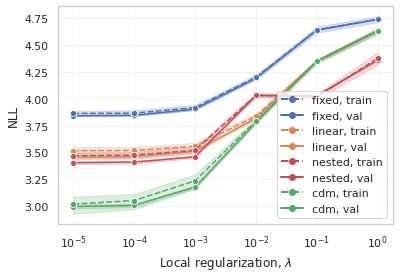

In [75]:
custom_lines = [Line2D([0], [0], color=palette[1], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[1], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[2], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[2], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[4], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[4], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='-', marker='o', lw=2)]
custom_labels = ['fixed, train', 
                 'fixed, val', 
                 'linear, train', 
                 'linear, val', 
                 'nested, train', 
                 'nested, val', 
                 'cdm, train', 
                 'cdm, val', ]
fig=plt.figure()
sns.lineplot(data=wd_results, x='weight decay', y='loss', hue='model', 
             style='loss type', style_order=['val', 'train'], marker='o')
plt.xscale('log')
plt.xlabel(r'Local regularization, $\lambda$')
plt.ylabel(r'NLL')
plt.legend(custom_lines, custom_labels, loc='lower right')
fig.savefig('../Figs/local_reg.pdf', format='pdf')

## CDM rank sweep over embedding_dim

In [80]:
def rank_sweep(i, dim):
    result=[]
    val = folds[i]
    train = pd.concat([df for j, df in enumerate(folds) if j!=i])
    train_choices, train_st_codex, train_prog_codex, train_ctip_codex, train_ballot = prep_dataset(train, program_attributes)
    (xval, xlval, yval), val_st_codex, val_ctip_codex = prep_valset(val, program_attributes, train_prog_codex)

    '''
    Train and validate models
    '''
    X_train = generate_covariate_matrix(program_attributes, train_st_codex, train_prog_codex, train_ctip_codex)
    X_val = generate_covariate_matrix(program_attributes, val_st_codex, train_prog_codex, val_ctip_codex)
    kwargs={'fixed_effects': True,
            'linear_terms': True,
            'covariates': X_train,
            'context': True,
            'embedding_dim': dim,
            'k': 1}
    model, tr_loss, num_epochs, tr_losses, _ = sp.train_stratified(ds=train_choices, num_items=len(train_prog_codex), epochs=1000, lr=1e-3, wd=1e-5, verbose=True, **kwargs)
    no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])
    result.append([i, dim, 'train', tr_loss, num_epochs, no_params])
    yval_hat = model.forward(xval, xlval, X_val)
    v_loss, v_loss_terms = model.loss_func(yval_hat, yval, xlval)
    result.append([i, dim, 'val', v_loss, num_epochs, no_params])
    return result

In [81]:
cdm_results = Parallel(n_jobs=-4)(delayed(rank_sweep)(i, dim) for i in range(kfolds) for dim in range(2,11))

/tmp/ipykernel_3497497/1571213881.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3497497/1571213881.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_3497497/1571213881.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykerne

Epoch: 25, Training Loss: 3.4711079597473145
Epoch: 50, Training Loss: 3.40484881401062
Epoch: 75, Training Loss: 3.3827831745147705
Epoch: 100, Training Loss: 3.3635058403015137
Epoch: 125, Training Loss: 3.354776620864868
Runtime: 510.24766182899475
Loss: 3.3543150424957275
Epoch: 25, Training Loss: 3.4864983558654785
Epoch: 50, Training Loss: 3.377899169921875
Epoch: 75, Training Loss: 3.2901413440704346
Epoch: 100, Training Loss: 3.203669786453247
Epoch: 125, Training Loss: 3.16778564453125
Epoch: 150, Training Loss: 3.155461311340332
Epoch: 175, Training Loss: 3.1507973670959473
Runtime: 527.5093524456024
Loss: 3.1501624584198
Epoch: 25, Training Loss: 3.474822521209717
Epoch: 50, Training Loss: 3.3108835220336914
Epoch: 75, Training Loss: 3.2222278118133545
Epoch: 100, Training Loss: 3.166159152984619
Epoch: 125, Training Loss: 3.1440224647521973
Epoch: 150, Training Loss: 3.1329691410064697
Epoch: 175, Training Loss: 3.127370834350586
Runtime: 651.8277666568756
Loss: 3.125066995

In [82]:
cdm_results = [subitem for item in cdm_results for subitem in item]
cdm_results = pd.DataFrame(cdm_results, columns=['fold', 'embedding dim', 'loss type', 'loss', 'num epochs', 'no params'])
cdm_results['loss'] = cdm_results['loss'].astype(float)
cdm_results['embedding dim'] = cdm_results['embedding dim'].astype(int)
cdm_results

,fold,embedding dim,loss type,loss,num epochs,no params
0,0,2,train,3.354315,129,788
1,0,2,val,3.200567,129,788
2,0,3,train,3.173913,432,1098
3,0,3,val,3.083611,432,1098
4,0,4,train,3.044724,626,1408
5,0,4,val,3.016858,626,1408
6,0,5,train,2.766543,1000,1718
7,0,5,val,2.995509,1000,1718
8,0,6,train,2.601036,1000,2028
9,0,6,val,2.971946,1000,2028


In [83]:
cdm_results.pivot_table(index='embedding dim', columns='loss type', values='loss')

loss type,train,val
embedding dim,,
2,3.194589,3.189167
3,3.091699,3.090312
4,3.005664,3.024228
5,2.925603,2.996986
6,2.869229,2.982901
7,2.824997,2.970306
8,2.805361,2.963907
9,2.779005,2.959602
10,2.764768,2.956051


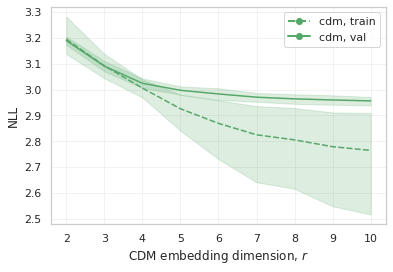

Epoch: 25, Training Loss: 3.4031736850738525
Epoch: 50, Training Loss: 3.285661458969116
Epoch: 75, Training Loss: 3.1503376960754395
Epoch: 100, Training Loss: 3.017589569091797
Epoch: 125, Training Loss: 2.885737419128418
Epoch: 150, Training Loss: 2.7687339782714844
Epoch: 175, Training Loss: 2.671261787414551
Epoch: 200, Training Loss: 2.596482276916504
Epoch: 225, Training Loss: 2.5415422916412354
Epoch: 250, Training Loss: 2.5005946159362793
Epoch: 275, Training Loss: 2.4689619541168213
Epoch: 300, Training Loss: 2.4435930252075195
Epoch: 325, Training Loss: 2.4226090908050537
Epoch: 350, Training Loss: 2.404860258102417
Epoch: 375, Training Loss: 2.389611005783081
Epoch: 400, Training Loss: 2.376354932785034
Epoch: 425, Training Loss: 2.3647217750549316
Epoch: 450, Training Loss: 2.354433536529541
Epoch: 475, Training Loss: 2.3452751636505127
Epoch: 500, Training Loss: 2.337080955505371
Epoch: 525, Training Loss: 2.3297221660614014
Epoch: 550, Training Loss: 2.3230955600738525
E

In [84]:
custom_lines = [Line2D([0], [0], color=palette[3], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='-', marker='o', lw=2)]
custom_labels = ['cdm, train', 
                 'cdm, val', ]
fig=plt.figure()
sns.lineplot(data=cdm_results, x='embedding dim', y='loss', style='loss type', 
             style_order = ['val', 'train'], color=sns.color_palette()[2])
plt.xlabel(r'CDM embedding dimension, $r$')
plt.ylabel(r'NLL')
plt.legend(custom_lines, custom_labels)
fig.savefig('../Figs/cdm_rank.pdf', format='pdf')

## Stratification sweep over lambda and k

In [85]:
def strat_sweep(i, k, lambda_reg, lr, model_name, fixed_effect, linear, context):
    result=[]
    val = folds[i]
    train = pd.concat([df for j, df in enumerate(folds) if j!=i])
    train_choices, train_st_codex, train_prog_codex, train_ctip_codex, train_ballot = prep_dataset(train, program_attributes)
    (xval, xlval, yval), val_st_codex, val_ctip_codex = prep_valset(val, program_attributes, train_prog_codex)
    
    X_train = generate_covariate_matrix(program_attributes, train_st_codex, train_prog_codex, train_ctip_codex)
    X_val = generate_covariate_matrix(program_attributes, val_st_codex, train_prog_codex, val_ctip_codex)
    kwargs={'fixed_effects': fixed_effect,
            'linear_terms': linear,
            'covariates': X_train,
            'context': context,
            'embedding_dim': 10,
            'k': k,
            'lambda_reg': lambda_reg}
    model, tr_loss, num_epochs, tr_losses, _ = sp.train_stratified(ds=train_choices, num_items=len(train_prog_codex), epochs=1000, lr=lr, wd=1e-5, verbose=True, **kwargs)
    no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])
    task_loss = tr_loss - np.array(tr_losses)[-1, -1]
    result.append([model_name, i, k, lambda_reg, lr, 'train', task_loss, num_epochs, no_params])
    result.append([model_name, i, k, lambda_reg, lr, 'train + reg', tr_loss, num_epochs, no_params])
    yval_hat = model.forward(xval, xlval, X_val)
    v_loss, v_loss_terms = model.loss_func(yval_hat, yval, xlval, train=False)
    result.append([model_name, i, k, lambda_reg, lr, 'val', v_loss, num_epochs, no_params])
    return result

In [ ]:
lambdas = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.]
lrs = [1e-3, 1e-3, 1e-3, 1e-3, 5e-4, 5e-4, 5e-4]
model_names = ['fixed', 'linear', 'cdm']
fixed_effects = [True, True, True]
linears = [False, True, True]
contexts = [False, False, True]

strat_results = Parallel(n_jobs=30)(delayed(strat_sweep)(i, k, lambda_reg, lr, model_name, fe, linear, context) 
                                    for i in range(kfolds) 
                                    for k in range(2,11) 
                                    for (lambda_reg, lr) in zip(lambdas, lrs)
                                    for model_name, fe, linear, context in zip(model_names, 
                                                                               fixed_effects, 
                                                                               linears, 
                                                                                contexts))
strat_results = [item for sublist in strat_results for item in sublist]

In [ ]:
strat_results_df = pd.DataFrame(strat_results, columns=['model', 'fold', 'k', 'lambda', 'lr', 'loss type', 'loss', 'num epochs', 'no params'])

In [ ]:
results2 = Parallel(n_jobs=30)(delayed(strat_sweep)(i, 1, 0.0, 1e-3, model_name, fe, linear, context) 
                               for i in range(kfolds) 
                               for model_name, fe, linear, context in zip(model_names, 
                                                                          fixed_effects, 
                                                                          linears, 
                                                                          contexts))
results2 = [item for sublist in results2 for item in sublist]
results2 = pd.DataFrame(results2, columns=['model','fold', 'k', 'lambda', 'lr', 'loss type', 'loss', 'num epochs', 'no params'])
strat_results_df2 = pd.concat([strat_results_df, results2])

In [ ]:
df_pl = strat_results_df2[strat_results_df2['model']=='fixed']
df_linear = strat_results_df2[strat_results_df2['model']=='linear']
df_cdm = strat_results_df2[strat_results_df2['model']=='cdm']

In [ ]:
df_pl['loss']=df_pl.loss.astype(float)
df_linear['loss']=df_linear.loss.astype(float)
df_cdm['loss']=df_cdm.loss.astype(float)

In [ ]:
pl_palette = sns.light_palette(sns.color_palette()[0], as_cmap=True)
linear_palette = sns.light_palette(sns.color_palette()[1], as_cmap=True)
cdm_palette = sns.light_palette(sns.color_palette()[2], as_cmap=True)

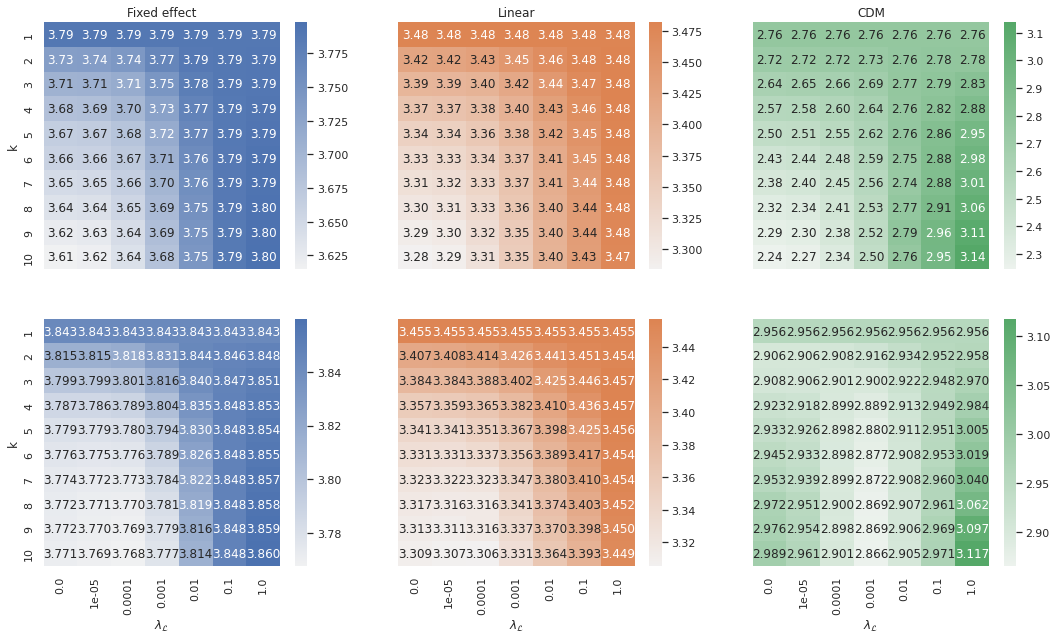

In [401]:
fig, ax = plt.subplots(2,3,figsize=(18, 10), sharex=True, sharey=True)

pt_pl = pd.pivot_table(df_pl[df_pl['loss type']=='train'], values='loss', index='k', columns='lambda')
pt_linear = pd.pivot_table(df_linear[df_linear['loss type']=='train'], values='loss', index='k', columns='lambda')
pt_cdm = pd.pivot_table(df_cdm[df_cdm['loss type']=='train'], values='loss', index='k', columns='lambda')
pt_pl.fillna(value=pt_pl.loc[1,0.0], inplace=True)
pt_linear.fillna(value=pt_linear.loc[1,0.0], inplace=True)
pt_cdm.fillna(value=pt_cdm.loc[1,0.0], inplace=True)
sns.heatmap(pt_pl, annot=True, fmt='.2f', cmap=pl_palette, ax=ax[0,0]).set(title = 'Fixed effect', xlabel='')
sns.heatmap(pt_linear, annot=True, fmt='.2f', cmap=linear_palette, ax=ax[0,1]).set(title = 'Linear', xlabel='', ylabel='')
sns.heatmap(pt_cdm, annot=True, fmt='.2f', cmap=cdm_palette, ax=ax[0,2]).set(title = 'CDM', xlabel='', ylabel='')

pt_pl = pd.pivot_table(df_pl[df_pl['loss type']=='val'], values='loss', index='k', columns='lambda')
pt_linear = pd.pivot_table(df_linear[df_linear['loss type']=='val'], values='loss', index='k', columns='lambda')
pt_cdm = pd.pivot_table(df_cdm[df_cdm['loss type']=='val'], values='loss', index='k', columns='lambda')
pt_pl.fillna(value=pt_pl.loc[1,0.0], inplace=True)
pt_linear.fillna(value=pt_linear.loc[1,0.0], inplace=True)
pt_cdm.fillna(value=pt_cdm.loc[1,0.0], inplace=True)
sns.heatmap(pt_pl, annot=True, fmt='.3f', cmap=pl_palette, ax=ax[1,0]).set(xlabel=r'$\lambda_\mathcal{L}$')
sns.heatmap(pt_linear, annot=True, fmt='.3f', cmap=linear_palette, ax=ax[1,1]).set(xlabel=r'$\lambda_\mathcal{L}$', ylabel='')
sns.heatmap(pt_cdm, annot=True, fmt='.3f', cmap=cdm_palette, ax=ax[1,2]).set(xlabel=r'$\lambda_\mathcal{L}$', ylabel='')
fig.savefig('../Figs/strat_hyperparam_heatmaps.pdf', format='pdf')

# Validation & test of all models

With tuned hyperparams

In [55]:
def train_val_test(i, model_name, fe, linear, context, strat, num_ranks=5):
    result=[]    
    val = folds[i]
    train = pd.concat([df for j, df in enumerate(folds) if j!=i])

    train_choices, train_st_codex, train_prog_codex, train_ctip_codex, train_ballot = prep_dataset(train, program_attributes)
    X_train = generate_covariate_matrix(program_attributes, train_st_codex, train_prog_codex, program_attributes.loc[train_prog_codex, 'school_id'], train_ctip_codex)
    (xval, xlval, yval), val_st_codex, val_ctip_codex = prep_valset(val, program_attributes, train_prog_codex)
    X_val = generate_covariate_matrix(program_attributes, val_st_codex, train_prog_codex, program_attributes.loc[train_prog_codex, 'school_id'], val_ctip_codex)
    (xtest, xltest, ytest), test_st_codex, test_ctip_codex = prep_valset(dataset_test, program_attributes_1819, train_prog_codex)
    X_test = generate_covariate_matrix(program_attributes_1819, test_st_codex, train_prog_codex, program_attributes_1819.loc[train_prog_codex, 'school_id'], test_ctip_codex)
    
    if model_name=='null':
        tr_loss, tr_loss_terms = compute_null_loss(train_choices[0], train_choices[1], train_choices[2], num_ranks=num_ranks)
        v_loss, v_loss_terms = compute_null_loss(xval, xlval, yval, num_ranks=num_ranks)
        test_loss, test_loss_terms = compute_null_loss(xtest, xltest, ytest, num_ranks=num_ranks)
        result.append([i, model_name, strat, 'train', 'all', float(tr_loss), 0.0, 0.0])
        result.append([i, model_name, strat, 'val', 'all', float(v_loss), 0.0, 0.0])
        result.append([i, model_name, strat, 'test', 'all', float(test_loss), 0.0, 0.0])
        for j in range(num_ranks):
            result.append([i, model_name, strat, 'train', j, float(tr_loss_terms[j]), 0.0, 0.0])
            result.append([i, model_name, strat, 'val', j, float(v_loss_terms[j]), 0.0, 0.0])
            result.append([i, model_name, strat, 'test', j, float(test_loss_terms[j]), 0.0, 0.0])
        return result
    else:
        kwargs={'fixed_effects': fe,
                'linear_terms': linear,
                'covariates': X_train,
                'context': context,
                'embedding_dim': 9,
                'k': 10 if (model_name in ['strat cdm', 'strat linear', 'strat fixed']) else 1,
                # 'k': 8 if (model_name=='strat cdm') else 9 if (model_name in ['strat linear', 'strat fixed']) else 1,
                'lambda_reg': 1e-3 if (model_name=='strat cdm') else 1e-4 if (model_name in ['strat linear', 'strat fixed']) else 0.0, 
                'num_ranks': num_ranks}
        model, tr_loss, num_epochs, tr_losses, _ = sp.train_stratified(ds=train_choices, num_items=len(train_prog_codex), epochs=1000, lr=1e-3, wd=1e-5, verbose=True, **kwargs)
        no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])    
        tr_losses = np.array(tr_losses)
        task_loss = tr_loss - tr_losses[-1, -1] if strat else tr_loss
        result.append([i, model_name, strat, 'train', 'all', float(task_loss), num_epochs, no_params])
        result.append([i, model_name, strat, 'train + reg', 'all', float(tr_loss), num_epochs, no_params])
        
        yval_hat = model.forward(xval, xlval, X_val)
        v_loss, v_loss_terms = model.loss_func(yval_hat, yval, xlval, train=False)
        result.append([i, model_name, strat, 'val', 'all', float(v_loss), num_epochs, no_params])
        
        ytest_hat = model.forward(xtest, xltest, X_test)
        test_loss, test_loss_terms = model.loss_func(ytest_hat, ytest, xltest, train=False)
        result.append([i, model_name, strat, 'test', 'all', float(test_loss), num_epochs, no_params])
        for j in range(num_ranks):
            result.append([i, model_name, strat, 'train', j, float(tr_losses[-1, j]), num_epochs, no_params])
            result.append([i, model_name, strat, 'val', j, float(v_loss_terms[j]), num_epochs, no_params])
            result.append([i, model_name, strat, 'test', j, float(test_loss_terms[j]), num_epochs, no_params])
        return result

In [ ]:
model_names=['null', 'fixed', 'strat fixed', 'linear', 'strat linear', 'cdm', 'strat cdm']
fixed_effects=[False, True, True, True, True, True, True]
linears=[False, False, False, True, True, True, True]
contexts=[False, False, False, False, False, True, True]
strats=[False, False, True, False, True, False, True]
train_val_test_results = Parallel(n_jobs=-4)(delayed(train_val_test)(i, model_name, fe, linear, context, strat) 
                                         for i in range(kfolds) 
                                         for model_name, fe, linear, context, strat in zip(model_names, 
                                                                                           fixed_effects, 
                                                                                           linears, 
                                                                                           contexts, 
                                                                                           strats))

In [ ]:
train_val_test_resultss = [subitem for item in train_val_test_results for subitem in item]
train_val_test_df = pd.DataFrame(train_val_test_resultss, columns=['fold', 'model name', 'stratified', 'loss type', 'rank', 'loss', 'num epochs', 'no params'])
train_val_test_df

In [ ]:
train_val_test_df['model'] = [name.split()[-1] for name in train_val_test_df['model name']]

In [ ]:
rank_df = train_val_test_df[(train_val_test_df['rank']!='all') & (train_val_test_df['loss type']!='train + reg')]
overall_df = train_val_test_df[(train_val_test_df['rank']=='all') & (train_val_test_df['loss type']!='train + reg')]

# Full training

## Load test attributes

In [76]:
school_attributes_1819 = pd.read_csv('../Cleaned Data/schools_rehauled_1819.csv', index_col='school_id')

school_attributes_1819.loc[476, 'math_scores_1819'] = np.mean([2337.8, 2393.9, 2397.7])
school_attributes_1819.loc[476, 'eng_scores_1819'] = np.mean([2337.8, 2393.9, 2397.7])
school_attributes_1819.loc[507, 'math_scores_1819'] = np.mean([2346.1, 2408.2, 2407.7])
school_attributes_1819.loc[507, 'eng_scores_1819'] = np.mean([2332.8, 2411.4, 2392.1])
school_attributes_1819.loc[537, 'math_scores_1819'] = np.mean([2362.8, 2401.8, 2453.5])
school_attributes_1819.loc[537, 'eng_scores_1819'] = np.mean([2369.1, 2413.7, 2468.5])

school_attributes_1819['avg_scores_1819'] = school_attributes_1819[['eng_scores_1819', 'math_scores_1819']].mean(axis=1)
school_attributes_1819['avg_scores_1819'] = school_attributes_1819['avg_scores_1819'].subtract(school_attributes_1819['avg_scores_1819'].min())\
                                            .divide(school_attributes_1819['avg_scores_1819'].max() - school_attributes_1819['avg_scores_1819'].min())
for column in ['ela_color', 'math_color', 'chronic_color', 'suspension_color']:
    school_attributes_1819[column].replace(['Red', 'Orange', 'Yellow', 'Green', 'Blue'], [1.,2.,3.,4.,5.], inplace=True)
school_attributes_1819['AvgColorIndex'] = school_attributes_1819[['ela_color', 'math_color', 'chronic_color', 'suspension_color']].mean(numeric_only=True, axis=1)
school_attributes_1819['% FRL 2019-2022'] = detailed_school_attributes.loc[school_attributes_1819.index,'% FRL']
school_attributes_1819['has_before_school_progs'] = detailed_school_attributes.loc[school_attributes_1819.index,'Has Before School Programs'].map({'Yes':1, 'No':0})
school_attributes_1819['has_after_school_progs'] = detailed_school_attributes.loc[school_attributes_1819.index,'Has After School Programs'].map({'Yes':1, 'No':0})


In [77]:
program_attributes_1819 = pd.read_csv('../Cleaned Data/programs_1819.csv', index_col='program_id')
program_attributes_1819['school_id'] = program_attributes_1819.school_id.astype(int)
program_attributes_1819['nest_membership'] = [prog_to_nest[program_type] for program_type in program_attributes_1819['program_type']]
program_attributes_1819['AvgColorIndex'] = [school_attributes_1819.loc[school,'AvgColorIndex'] for school in program_attributes_1819.school_id]
program_attributes_1819['portion_FRL'] = [school_attributes_1819.loc[school,'% FRL 2019-2022']/100. for school in program_attributes_1819.school_id]
program_attributes_1819['has_before_school_progs'] = [school_attributes_1819.loc[school,'has_before_school_progs'] for school in program_attributes_1819.school_id]
program_attributes_1819['has_after_school_progs'] = [school_attributes_1819.loc[school,'has_after_school_progs'] for school in program_attributes_1819.school_id]
program_attributes_1819 = pd.concat([program_attributes_1819, program_attributes[~program_attributes.index.isin(program_attributes_1819.index)]])
program_attributes_1819['nest_id'] = [nests.index(nest) for nest in program_attributes_1819['nest_membership']]

In [78]:
# Choices: [x, x_extra, slots_chosen] where
# x = np.stack([padded_choice_sets, padded_chosen_sets], axis=-1)
# x_extra = np.stack([np.array(whose_choice_concat), choice_set_lengths, chosen_set_lengths], axis=1)

df_test = df[df.year.isin(TEST_SET_YEARS)]
dataset_test = clean_dataframe(df_test, program_attributes_1819)

## Train

In [79]:
X = generate_covariate_matrix(program_attributes, student_codex, program_codex, ctip_codex)

In [80]:
(xtest, xltest, ytest), student_codex_test, ctip_codex_test = prep_valset(dataset_test, program_attributes, program_codex)
X_test = generate_covariate_matrix(program_attributes_1819, student_codex_test, program_codex, ctip_codex_test)

In [81]:
print('No. students: ', len(student_codex_test))
print('No. programs: ', num_programs)
print('Avg. len of ranking', dataset_test.num_ranked.mean())
print('No. training examples', xtest.shape[0])
print('% CTIP1', ctip_codex_test.mean())

No. students:  4260
No. programs:  154
Avg. len of ranking 7.028169014084507
No. training examples 29216
% CTIP1 0.1880281690140845


In [82]:
def full_train_test(model_string, fe, linear, context, strat, num_ranks=5):
    result=[]
    train = pd.concat([df for j, df in enumerate(folds)])

    train_choices, train_st_codex, train_prog_codex, train_ctip_codex, train_ballot = prep_dataset(train, program_attributes)
    X_train = generate_covariate_matrix(program_attributes, train_st_codex, train_prog_codex, train_ctip_codex)
    (xtest, xltest, ytest), test_st_codex, test_ctip_codex = prep_valset(dataset_test, program_attributes_1819, train_prog_codex)
    X_test = generate_covariate_matrix(program_attributes_1819, test_st_codex, train_prog_codex, test_ctip_codex)
    
    if model_string=='null':
        tr_loss, tr_loss_terms = compute_null_loss(train_choices[0], train_choices[1], train_choices[2], num_ranks=num_ranks)
        test_loss, test_loss_terms = compute_null_loss(xtest, xltest, ytest, num_ranks=num_ranks)
        result.append([model_string, strat, 'train', 'all', float(tr_loss), 0.0, 0.0])
        result.append([model_string, strat, 'test', 'all', float(test_loss), 0.0, 0.0])
        for j in range(num_ranks):
            result.append([model_string, strat, 'train', j, float(tr_loss_terms[j]), 0.0, 0.0])
            result.append([model_string, strat, 'test', j, float(test_loss_terms[j]), 0.0, 0.0])
        return ((model_string, None), result)
    elif model_string=='nested':
        nest_memberships = program_attributes_1819.loc[train_prog_codex,'nest_id'].values
        kwargs={'fixed_effects': True,
                'linear_terms': True,
                'covariates': X_train,
                'num_nests': len(nests),
                'nest_memberships': nest_memberships,
                'num_ranks': num_ranks}
        model, tr_loss, num_epochs, tr_losses, _ = sp.train_stratified(ds=train_choices, 
                                                                       num_items=len(train_prog_codex), 
                                                                       epochs=1000, 
                                                                       lr=1e-3, 
                                                                       wd=1e-5, 
                                                                       verbose=True, 
                                                                       Model=sp.Nested_MNL,
                                                                       **kwargs)
        no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])    
        tr_losses = np.array(tr_losses)
        task_loss = tr_loss - tr_losses[-1, -1] if strat else tr_loss
        result.append([model_string, False, 'train', 'all', float(task_loss), num_epochs, no_params])
        result.append([model_string, False, 'train + reg', 'all', float(tr_loss), num_epochs, no_params])
        
        ytest_hat = model.forward(xtest, xltest, X_test)
        test_loss, test_loss_terms = model.loss_func(ytest_hat, ytest, xltest, train=False)
        result.append([model_string, False, 'test', 'all', float(test_loss), num_epochs, no_params])
        for j in range(num_ranks):
            result.append([model_string, False, 'train', j, float(tr_losses[-1, j]), num_epochs, no_params])
            result.append([model_string, False, 'test', j, float(test_loss_terms[j]), num_epochs, no_params])
        return ((model_string, model), result)
    else:
        kwargs={'fixed_effects': fe,
                'linear_terms': linear,
                'covariates': X_train,
                'context': context,
                'embedding_dim': 10,
                'k': 10 if (model_string in ['strat cdm', 'strat linear', 'strat fixed']) else 1,
                # 'k': 8 if (model_name=='strat cdm') else 9 if (model_name in ['strat linear', 'strat fixed']) else 1,
                'lambda_reg': 1e-3 if (model_string=='strat cdm') else 1e-4 if (model_string in ['strat linear', 'strat fixed']) else 0.0, 
                'num_ranks': num_ranks}
        model, tr_loss, num_epochs, tr_losses, _ = sp.train_stratified(ds=train_choices, num_items=len(train_prog_codex), epochs=1000, lr=1e-3, wd=1e-5, verbose=True, **kwargs)
        no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])    
        tr_losses = np.array(tr_losses)
        task_loss = tr_loss - tr_losses[-1, -1] if strat else tr_loss
        result.append([model_string, strat, 'train', 'all', float(task_loss), num_epochs, no_params])
        result.append([model_string, strat, 'train + reg', 'all', float(tr_loss), num_epochs, no_params])
        
        ytest_hat = model.forward(xtest, xltest, X_test)
        test_loss, test_loss_terms = model.loss_func(ytest_hat, ytest, xltest, train=False)
        result.append([model_string, strat, 'test', 'all', float(test_loss), num_epochs, no_params])
        for j in range(num_ranks):
            result.append([model_string, strat, 'train', j, float(tr_losses[-1, j]), num_epochs, no_params])
            result.append([model_string, strat, 'test', j, float(test_loss_terms[j]), num_epochs, no_params])
        return ((model_string, model), result)

In [83]:
model_names=['null', 'fixed', 'strat fixed', 'linear', 'strat linear', 'cdm', 'strat cdm', 'nested']
fixed_effects=[False, True, True, True, True, True, True, True]
linears=[False, False, False, True, True, True, True, True]
contexts=[False, False, False, False, False, True, True, False]
strats=[False, False, True, False, True, False, True, False]
full_train_results = Parallel(n_jobs=30)(delayed(full_train_test)(model_string, fe, linear, context, strat) 
                                         for model_string, fe, linear, context, strat in zip(model_names, 
                                                                                             fixed_effects, 
                                                                                             linears, 
                                                                                             contexts, 
                                                                                             strats))

Epoch: 25, Training Loss: 4.050492763519287
Epoch: 50, Training Loss: 3.867922306060791
Epoch: 75, Training Loss: 3.821742057800293
Epoch: 100, Training Loss: 3.80718731880188
Epoch: 125, Training Loss: 3.8012681007385254
Runtime: 53.48047709465027
Loss: 3.7995455265045166
Epoch: 25, Training Loss: 3.74403977394104
Epoch: 50, Training Loss: 3.532989501953125
Epoch: 75, Training Loss: 3.481962203979492
Epoch: 100, Training Loss: 3.4701812267303467
Runtime: 73.44642519950867
Loss: 3.4685380458831787
Epoch: 25, Training Loss: 4.050818920135498
Epoch: 50, Training Loss: 3.8233189582824707
Epoch: 75, Training Loss: 3.7530038356781006
Epoch: 100, Training Loss: 3.728452205657959
Epoch: 125, Training Loss: 3.718672513961792
Epoch: 150, Training Loss: 3.714470863342285
Runtime: 92.3128445148468
Loss: 3.7141640186309814
Epoch: 25, Training Loss: 3.679596424102783
Epoch: 50, Training Loss: 3.4191455841064453
Epoch: 75, Training Loss: 3.3369529247283936
Epoch: 100, Training Loss: 3.30782032012939

In [84]:
model_dict = {model_tuple[0]: model_tuple[1] for model_tuple, _ in full_train_results}
full_train_df = pd.DataFrame([subitem for _, result in full_train_results for subitem in result],
                             columns=['model name', 'stratified', 'loss type', 'rank', 'loss', 'num epochs', 'no params'])
full_train_df['model'] = [name.split()[-1] for name in full_train_df['model name']]

## Loss

In [85]:
model_dict['nested'].scale_parameter.weight, nests

(Parameter containing:
 tensor([[0.7443],
         [0.5652],
         [0.4777],
         [0.4075],
         [0.7279],
         [0.5443],
         [0.2947]], requires_grad=True),
 ['Chinese Language',
  'Filipino Language',
  'General Education',
  'Japanese Language',
  'Korean Language',
  'Spanish Language',
  'Special Education'])

In [86]:
rank_results = full_train_df[(full_train_df['rank']!='all') & (full_train_df['loss type']!='train + reg')]
overall_results = full_train_df[(full_train_df['rank']=='all') & (full_train_df['loss type']!='train + reg')]

In [87]:
overall_results[overall_results['loss type']=='test']

,model name,stratified,loss type,rank,loss,num epochs,no params,model
1,null,False,test,all,4.962845,0.0,0.0,null
14,fixed,False,test,all,4.060575,139.0,155.0,fixed
27,strat fixed,True,test,all,3.974925,153.0,1550.0,fixed
40,linear,False,test,all,3.486336,112.0,168.0,linear
53,strat linear,True,test,all,3.335953,145.0,1680.0,linear
66,cdm,False,test,all,2.942050,220.0,3268.0,cdm
79,strat cdm,True,test,all,2.857001,476.0,32680.0,cdm
92,nested,False,test,all,3.446152,225.0,175.0,nested


/tmp/ipykernel_3357181/2752415363.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(['null', 'fixed', 'fixed, strat.', 'linear', 'linear, strat.', 'cdm', 'cdm, strat.', 'nested'], fontdict={'horizontalalignment': 'right'})


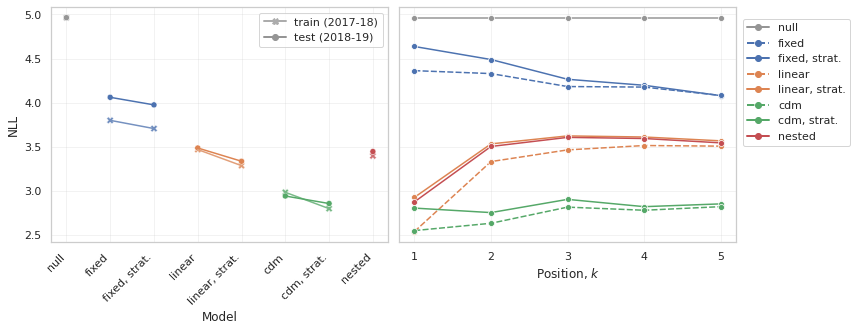

In [88]:
custom_lines_0 = [Line2D([0], [0], color=sns.light_palette(palette[0], n_colors=5)[3], linestyle='-', marker='X', lw=2),
                  Line2D([0], [0], color=sns.light_palette(palette[0], n_colors=5)[-1], linestyle='-', marker='o', lw=2)]
custom_lines_1 = [Line2D([0], [0], color=palette[0], linestyle='-', marker='o', lw=2),
                  Line2D([0], [0], color=palette[1], linestyle='--', marker='o', lw=2),
                  Line2D([0], [0], color=palette[1], linestyle='-', marker='o', lw=2),
                  Line2D([0], [0], color=palette[2], linestyle='--', marker='o', lw=2),
                  Line2D([0], [0], color=palette[2], linestyle='-', marker='o', lw=2),
                  Line2D([0], [0], color=palette[3], linestyle='--', marker='o', lw=2),
                  Line2D([0], [0], color=palette[3], linestyle='-', marker='o', lw=2),
                  Line2D([0], [0], color=palette[4], linestyle='-', marker='o', lw=2)]

fig, ax = plt.subplots(1,2,figsize=(12,4.7),sharey=True)
sns.scatterplot(data=overall_results[(overall_results['loss type']=='train')], x='model name', y='loss', 
                hue='model', marker='X', s=50, alpha=0.8, palette=palette, ax=ax[0])
sns.scatterplot(data=overall_results[(overall_results['loss type']=='test')], x='model name', y='loss', 
                hue='model', marker='o', palette=palette, ax=ax[0])
ytrain=np.array([overall_results[(overall_results['model name']==model)&
                                 (overall_results['loss type']=='train')]['loss'].values for model in model_names]).flatten()
ytest=np.array([overall_results[(overall_results['model name']==model)&
                                (overall_results['loss type']=='test')]['loss'].values for model in model_names]).flatten()
sns.lineplot(x=[1,2], y=[ytrain[1], ytrain[2]], color=sns.light_palette(palette[1], n_colors=5)[3], ax=ax[0])
sns.lineplot(x=[1,2], y=[ytest[1], ytest[2]], color=palette[1], ax=ax[0])
sns.lineplot(x=[3,4], y=[ytrain[3], ytrain[4]], color=sns.light_palette(palette[2], n_colors=5)[3], ax=ax[0])
sns.lineplot(x=[3,4], y=[ytest[3], ytest[4]], color=palette[2], ax=ax[0])
sns.lineplot(x=[5,6], y=[ytrain[5], ytrain[6]], color=sns.light_palette(palette[3], n_colors=5)[3], ax=ax[0])
sns.lineplot(x=[5,6], y=[ytest[5], ytest[6]], color=palette[3], ax=ax[0])

sns.lineplot(data=rank_results[(rank_results['loss type']=='test')], 
             x='rank', y='loss', hue='model', style='stratified', palette=palette, marker='o', ax=ax[1])

ax[0].set_ylabel('NLL')
ax[0].set_xlabel('Model')
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xticklabels(['null', 'fixed', 'fixed, strat.', 'linear', 'linear, strat.', 'cdm', 'cdm, strat.', 'nested'], fontdict={'horizontalalignment': 'right'})
ax[0].legend(custom_lines_0, ['train (2017-18)', 
                              'test (2018-19)'])
ax[1].set_xlabel(r'Position, $k$')
ax[1].set_xticks([0,1,2,3,4])
ax[1].set_xticklabels([1,2,3,4,5])
ax[1].legend(custom_lines_1, ['null', 
                              'fixed', 
                              'fixed, strat.', 
                              'linear', 
                              'linear, strat.', 
                              'cdm', 
                              'cdm, strat.',
                              'nested'], loc=(1.02, 0.41))
fig.tight_layout()
fig.savefig('../Figs/nll_losses.pdf', format='pdf', bbox_inches='tight')

## Comparison w/ Nested

### Examine spec. ed. student likelihoods at pos. 1 & 2

In [89]:
sample_student =  888006603
sample_student_id = student_codex_test.index(888006603)
top_choice = '420-MS-KG'
top_choice_id = program_codex.index(top_choice)

choice_set = list(np.arange(num_programs))
choice_set.remove(top_choice_id)
choice_set.append(num_programs)
x1 = t.Tensor(np.vstack([np.arange(num_programs)[None,:], np.array(choice_set)[None,:]])).long()
x2 = np.full((2,num_programs), fill_value=num_programs)
x2[1,0] = top_choice_id
x = t.Tensor(np.dstack([x1,x2])).long()
x_extra = t.tensor([[sample_student_id, num_programs, 0],[sample_student_id, num_programs-1, 1]])
likelihoods = np.exp(model_dict['linear'].forward(x, x_extra, X_test).detach().numpy()), np.exp(model_dict['nested'].forward(x, x_extra, X_test).detach().numpy()), np.exp(model_dict['cdm'].forward(x, x_extra, X_test).detach().numpy())
for likelihood in likelihoods:
    second_row = list(likelihood[1,:])
    second_row.insert(top_choice_id, 0.0)
    likelihood[1,:] = np.array(second_row[:-1])

In [90]:
probs_df_list = []
[probs_df_list.extend(zip([model]*likelihood.size, 
                          program_codex+program_codex, 
                          list(program_attributes_1819.loc[program_codex, 'nest_membership'].values)+list(program_attributes_1819.loc[program_codex, 'nest_membership'].values), 
                          ['top choice']*num_programs+['second choice']*num_programs, 
                          likelihood.flatten())) for model, likelihood in zip(['linear', 'nested', 'cdm'], likelihoods)]
probs_df = pd.DataFrame(probs_df_list, columns=['Model', 'Program', 'Nest Membership', 'Position', 'Probability'])
nest_order = ['Korean Language','Japanese Language','Filipino Language','Chinese Language','Spanish Language','General Education','Special Education']
probs_df['Nest Membership'] = pd.Categorical(probs_df['Nest Membership'], nest_order)
probs_df.head()

,Model,Program,Nest Membership,Position,Probability
0,linear,413-GE-KG,General Education,top choice,0.010422
1,linear,413-SA-KG,Special Education,top choice,0.000060
2,linear,420-GE-KG,General Education,top choice,0.017465
3,linear,420-MS-KG,Special Education,top choice,0.000163
4,linear,420-SE-KG,Spanish Language,top choice,0.007064


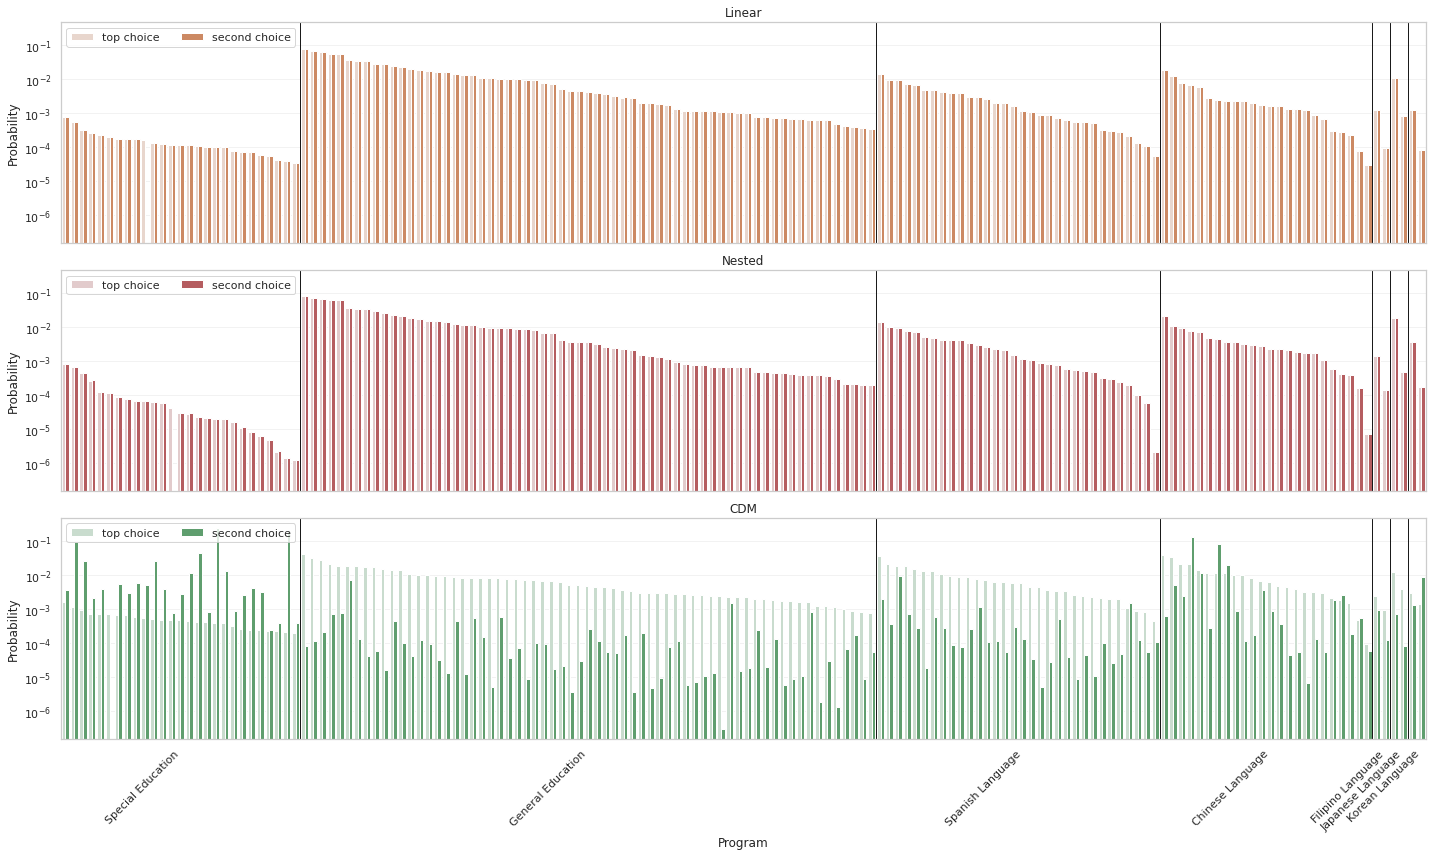

In [91]:
fig, ax = plt.subplots(3,1,figsize=(20,12),sharey=True,sharex=True)
sns.barplot(data = probs_df[(probs_df.Model=='linear')], x='Program', order=probs_df[(probs_df.Model=='linear')&(probs_df.Position=='top choice')].sort_values(by=['Nest Membership', 'Probability'], ascending=False).set_index('Program').index, 
            y='Probability', hue='Position', palette=sns.light_palette(palette[2], n_colors=5)[1:5:3], ax=ax[0])
sns.barplot(data = probs_df[(probs_df.Model=='nested')], x='Program', order=probs_df[(probs_df.Model=='nested')&(probs_df.Position=='top choice')].sort_values(by=['Nest Membership', 'Probability'], ascending=False).set_index('Program').index, 
            y='Probability', hue='Position', palette=sns.light_palette(palette[-1], n_colors=5)[1:5:3], ax=ax[1])
sns.barplot(data = probs_df[(probs_df.Model=='cdm')], x='Program', order=probs_df[(probs_df.Model=='cdm')&(probs_df.Position=='top choice')].sort_values(by=['Nest Membership', 'Probability'], ascending=False).set_index('Program').index,
            y='Probability', hue='Position', palette=sns.light_palette(palette[3], n_colors=5)[1:5:3], ax=ax[2])
nest_value_counts = probs_df[(probs_df.Model=='linear')&(probs_df.Position=='top choice')]['Nest Membership'].value_counts()
for i in range(3):
    ax[i].set_yscale('log')
    # ax[i].set_ylim(1e-6,1.0)
    ax[i].set_xlabel('')
    ax[i].axvline(x=nest_value_counts.loc[nest_order[-1]]-0.5, color='k', linewidth=1)
    ax[i].axvline(x=nest_value_counts.loc[nest_order[-2:]].sum()-0.5, color='k', linewidth=1)
    ax[i].axvline(x=nest_value_counts.loc[nest_order[-3:]].sum()-0.5, color='k', linewidth=1)
    ax[i].axvline(x=nest_value_counts.loc[nest_order[-4:]].sum()-0.5, color='k', linewidth=1)
    ax[i].axvline(x=nest_value_counts.loc[nest_order[-5:]].sum()-0.5, color='k', linewidth=1)
    ax[i].axvline(x=nest_value_counts.loc[nest_order[-6:]].sum()-0.5, color='k', linewidth=1)
    ax[i].legend(loc='upper left', ncol=2)
ax[0].set_title(r'Linear')
ax[1].set_title(r'Nested')
ax[2].set_title(r'CDM')
ax[2].set_xticks(ticks = [nest_value_counts.loc[nest_order[-1]]//2, 
                          nest_value_counts.loc[nest_order[-1]]+nest_value_counts.loc[nest_order[-2]]//2, 
                          nest_value_counts.loc[nest_order[-2:]].sum()+nest_value_counts.loc[nest_order[-3]]//2,
                          nest_value_counts.loc[nest_order[-3:]].sum()+nest_value_counts.loc[nest_order[-4]]//2,
                          nest_value_counts.loc[nest_order[-4:]].sum()+nest_value_counts.loc[nest_order[-5]]//2,
                          nest_value_counts.loc[nest_order[-5:]].sum()+nest_value_counts.loc[nest_order[-6]]//2,
                          nest_value_counts.loc[nest_order[-6:]].sum()+nest_value_counts.loc[nest_order[-7]]//2],
                labels = nest_order[::-1])
ax[2].set_xlabel('Program')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, fontdict={'horizontalalignment':'right'})
plt.tight_layout()
fig.savefig('../Figs/nested_probabilities.pdf', format='pdf')

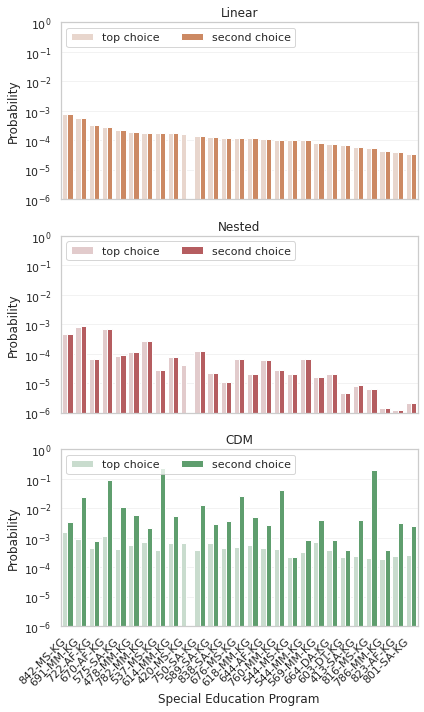

In [92]:
fig, ax = plt.subplots(3,1,figsize=(6,10),sharey=True,sharex=True)
xaxis_order = probs_df[(probs_df.Model=='linear')&(probs_df.Position=='top choice')&(probs_df['Nest Membership']=='Special Education')].sort_values(by='Probability', ascending=False).set_index('Program').index
sns.barplot(data = probs_df[(probs_df.Model=='linear')&(probs_df['Nest Membership']=='Special Education')], 
            x='Program', order=xaxis_order, y='Probability', hue='Position', 
            palette=sns.light_palette(palette[2], n_colors=5)[1:5:3], ax=ax[0])
sns.barplot(data = probs_df[(probs_df.Model=='nested')&(probs_df['Nest Membership']=='Special Education')], 
            x='Program', order=xaxis_order, y='Probability', hue='Position', 
            palette=sns.light_palette(palette[-1], n_colors=5)[1:5:3], ax=ax[1])
sns.barplot(data = probs_df[(probs_df.Model=='cdm')&(probs_df['Nest Membership']=='Special Education')], 
            x='Program', order=xaxis_order, y='Probability', hue='Position', 
            palette=sns.light_palette(palette[3], n_colors=5)[1:5:3], ax=ax[2])
# sns.barplot(data = probs_df[(probs_df.Model=='nested')], x='Program', order=probs_df[(probs_df.Model=='nested')&(probs_df.Position=='top choice')].sort_values(by=['Nest Membership', 'Probability'], ascending=False).set_index('Program').index, 
#             y='Probability', hue='Position', palette=sns.light_palette(palette[-1], n_colors=5)[1:5:3], ax=ax[1])
# sns.barplot(data = probs_df[(probs_df.Model=='cdm')], x='Program', order=probs_df[(probs_df.Model=='cdm')&(probs_df.Position=='top choice')].sort_values(by=['Nest Membership', 'Probability'], ascending=False).set_index('Program').index,
#             y='Probability', hue='Position', palette=sns.light_palette(palette[3], n_colors=5)[1:5:3], ax=ax[2])
# nest_value_counts = probs_df[(probs_df.Model=='linear')&(probs_df.Position=='top choice')]['Nest Membership'].value_counts()
for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_ylim(1e-6,1.0)
    ax[i].set_xlabel('')
    # ax[i].axvline(x=nest_value_counts.loc[nest_order[-1]]-0.5, color='k', linewidth=1)
    # ax[i].axvline(x=nest_value_counts.loc[nest_order[-2:]].sum()-0.5, color='k', linewidth=1)
    # ax[i].axvline(x=nest_value_counts.loc[nest_order[-3:]].sum()-0.5, color='k', linewidth=1)
    # ax[i].axvline(x=nest_value_counts.loc[nest_order[-4:]].sum()-0.5, color='k', linewidth=1)
    # ax[i].axvline(x=nest_value_counts.loc[nest_order[-5:]].sum()-0.5, color='k', linewidth=1)
    # ax[i].axvline(x=nest_value_counts.loc[nest_order[-6:]].sum()-0.5, color='k', linewidth=1)
    ax[i].legend(loc='upper left', ncol=2)
ax[0].set_title(r'Linear')
ax[1].set_title(r'Nested')
ax[2].set_title(r'CDM')
# ax[2].set_xticks(ticks = [nest_value_counts.loc[nest_order[-1]]//2, 
#                           nest_value_counts.loc[nest_order[-1]]+nest_value_counts.loc[nest_order[-2]]//2, 
#                           nest_value_counts.loc[nest_order[-2:]].sum()+nest_value_counts.loc[nest_order[-3]]//2,
#                           nest_value_counts.loc[nest_order[-3:]].sum()+nest_value_counts.loc[nest_order[-4]]//2,
#                           nest_value_counts.loc[nest_order[-4:]].sum()+nest_value_counts.loc[nest_order[-5]]//2,
#                           nest_value_counts.loc[nest_order[-5:]].sum()+nest_value_counts.loc[nest_order[-6]]//2,
#                           nest_value_counts.loc[nest_order[-6:]].sum()+nest_value_counts.loc[nest_order[-7]]//2],
#                 labels = nest_order[::-1])
ax[2].set_xlabel('Special Education Program')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45, fontdict={'horizontalalignment':'right'})
plt.tight_layout()
fig.savefig('../Figs/nested_probabilities_speced.pdf', format='pdf')

## Top-K CDM

In [93]:
def top_k_cdm(k, num_ranks=5):
    result=[]    
    train = pd.concat([df for df in folds])

    train_choices, train_st_codex, train_prog_codex, train_ctip_codex, train_ballot = prep_dataset(train, program_attributes)
    X_train = generate_covariate_matrix(program_attributes, train_st_codex, train_prog_codex, train_ctip_codex)
    (xtest, xltest, ytest), test_st_codex, test_ctip_codex = prep_valset(dataset_test, program_attributes_1819, train_prog_codex)
    X_test = generate_covariate_matrix(program_attributes_1819, test_st_codex, train_prog_codex, test_ctip_codex)
    
    kwargs={'fixed_effects': True,
            'linear_terms': True,
            'covariates': X_train,
            'context': True,
            'embedding_dim': 10,
            'top_k': k,
            'num_ranks': num_ranks}
    model, tr_loss, num_epochs, tr_losses, _ = sp.train_stratified(ds=train_choices, num_items=len(train_prog_codex), epochs=1000, lr=1e-3, wd=1e-5, verbose=True, **kwargs)
    no_params = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad])    
    tr_losses = np.array(tr_losses)
    result.append(['cdm', False, k, 'train', 'all', float(tr_loss), num_epochs, no_params])

    ytest_hat = model.forward(xtest, xltest, X_test)
    test_loss, test_loss_terms = model.loss_func(ytest_hat, ytest, xltest, train=False)
    result.append(['cdm', False, k, 'test', 'all', float(test_loss), num_epochs, no_params])
    for j in range(num_ranks):
        result.append(['cdm', False, k, 'train', j, float(tr_losses[-1, j]), num_epochs, no_params])
        result.append(['cdm', False, k, 'test', j, float(test_loss_terms[j]), num_epochs, no_params])
    return result

In [94]:
top_k_cdm_results = Parallel(n_jobs=-4)(delayed(top_k_cdm)(k) for k in np.arange(5)+1)
top_k_cdm_df = pd.DataFrame([subitem for result in top_k_cdm_results for subitem in result], 
                             columns=['model name', 'stratified', 'k', 'loss type', 'rank', 'loss', 'num epochs', 'no params'])

Epoch: 25, Training Loss: 3.2748465538024902
Epoch: 50, Training Loss: 3.1190309524536133
Epoch: 75, Training Loss: 3.029891014099121
Epoch: 100, Training Loss: 2.98203706741333
Epoch: 125, Training Loss: 2.9536149501800537
Epoch: 150, Training Loss: 2.933540105819702
Epoch: 175, Training Loss: 2.9177799224853516
Epoch: 200, Training Loss: 2.9048004150390625
Epoch: 225, Training Loss: 2.8938488960266113
Epoch: 250, Training Loss: 2.8844661712646484
Epoch: 275, Training Loss: 2.8763527870178223
Epoch: 300, Training Loss: 2.8692514896392822
Epoch: 325, Training Loss: 2.8629238605499268
Epoch: 350, Training Loss: 2.8573195934295654
Epoch: 375, Training Loss: 2.852210283279419
Epoch: 400, Training Loss: 2.8476438522338867
Epoch: 425, Training Loss: 2.8435728549957275
Epoch: 450, Training Loss: 2.8399550914764404
Epoch: 475, Training Loss: 2.836827278137207
Runtime: 2041.4492483139038
Loss: 2.8367385864257812


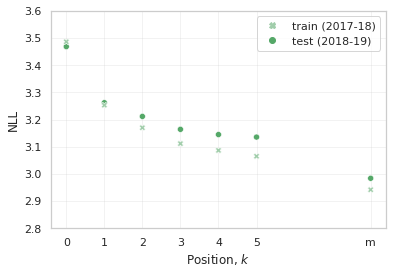

In [111]:
temp_palette = [palette[3],sns.light_palette(palette[3], n_colors=5)[2]]
custom_lines = [Line2D([0], [0], color=temp_palette[1], linestyle='', marker='X', lw=2),
                Line2D([0], [0], color=temp_palette[0], linestyle='', marker='o', lw=2)]

fig, ax = plt.subplots(1, 1)
sns.scatterplot(data=overall_results[overall_results['model name']=='linear'], 
                x=0, y='loss', hue='loss type', style='loss type', palette=temp_palette, legend=False, ax=ax)
sns.scatterplot(data=top_k_cdm_df[top_k_cdm_df['rank']=='all'], 
                x='k', y='loss', hue='loss type', style='loss type', palette=temp_palette, ax=ax)
sns.scatterplot(data=overall_results[overall_results['model name']=='cdm'], 
                x=8, y='loss', hue='loss type', style='loss type', palette=temp_palette, legend=False, ax=ax)
ax.set_ylabel('NLL')
ax.set_ylim(2.8,3.6)
ax.set_xlabel(r'Position, $k$')
ax.legend(custom_lines, ['train (2017-18)', 'test (2018-19)'])
ax.set_xticks([0,1,2,3,4,5,8])
ax.set_xticklabels([0,1,2,3,4,5,r'm'])
fig.savefig('../Figs/top_k_cdm.pdf', format='pdf')

## Parameter estimates

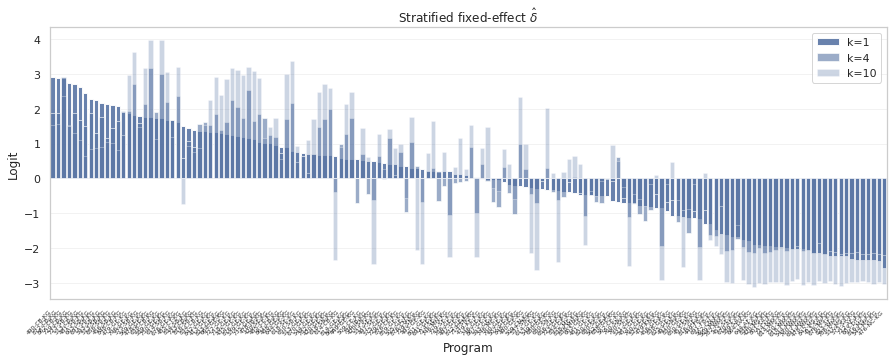

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
                       # , sharey=True, sharex=True)
pl_logits = pd.Series(model_dict['strat fixed'].logits[0].weight.detach().numpy()[:-1].flatten(), index=program_codex)
sorted_programs = pl_logits.sort_values(ascending=False).index

# pl_logits = pd.Series(model_dict['fixed'].logits[0].weight.detach().numpy()[:-1].flatten(), index=program_codex)
# pl_logits -= pl_logits.mean()
# sns.barplot(x='index', y=0, data=pl_logits.reset_index(), order=sorted_programs, color=palette[1], ax=ax[0]).set(
#     xlabel='',ylabel='Logit',title=r'Fixed-effect $\hat \delta$'
# )

strat_logits = [pd.Series(model_dict['strat fixed'].logits[i].weight.detach().numpy()[:-1].flatten(), index=program_codex) for i in range(model_dict['strat fixed'].k)]
shifted_logits = [logit - logit.mean() for logit in strat_logits]
sns.barplot(x='index', y=0, data=shifted_logits[0].reset_index(), order=sorted_programs, color=palette[1], alpha=0.9, label='k=1', ax=ax)
sns.barplot(x='index', y=0, data=shifted_logits[5].reset_index(), order=sorted_programs, color=palette[1], alpha=0.6, label='k=4', ax=ax)
sns.barplot(x='index', y=0, data=shifted_logits[9].reset_index(), order=sorted_programs, color=palette[1], alpha=0.3, label='k=10', ax=ax)
ax.set_ylabel('Logit')
ax.set_xlabel('Program')
ax.set_title('Stratified fixed-effect $\hat\delta$')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=6, fontdict={'horizontalalignment': 'right'})
plt.legend()
fig.savefig('../Figs/strat_logits.pdf', format='pdf', bbox_inches='tight')

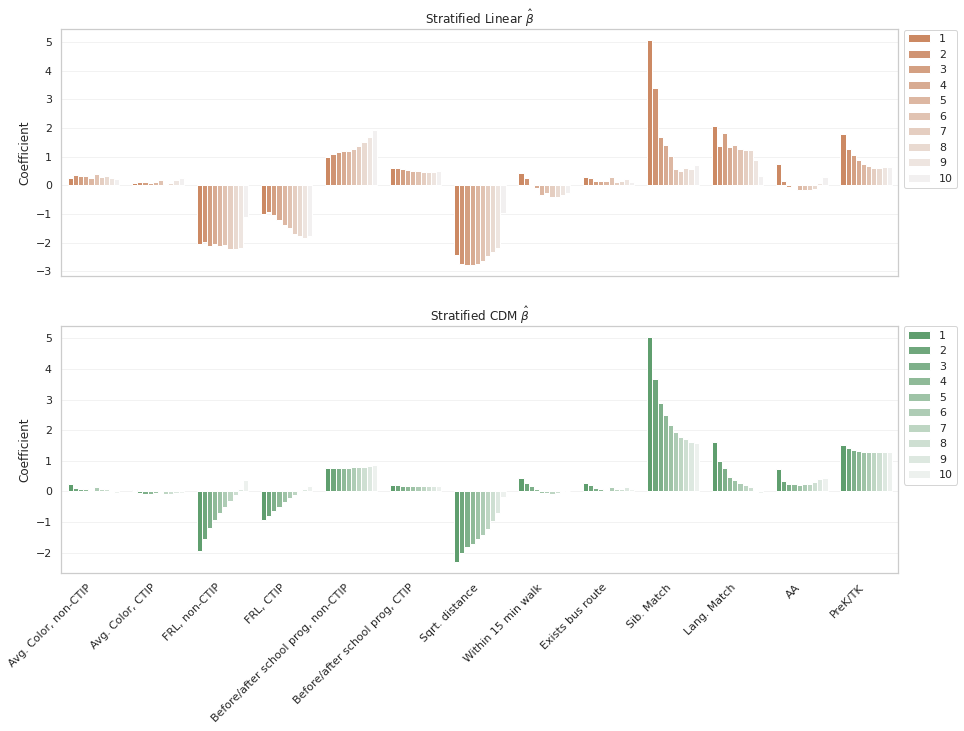

In [118]:
beta_linear = pd.concat([pd.DataFrame([beta.weight.detach().numpy().flatten(), covariate_names, np.full((len(covariate_names)), fill_value=i+1)]).transpose() for i, beta in enumerate(model_dict['strat linear'].beta)])
beta_linear.columns=['coefficient','covariate','k']

beta_cdm = pd.concat([pd.DataFrame([beta.weight.detach().numpy().flatten(), covariate_names, np.full((len(covariate_names)), fill_value=i+1)]).transpose() for i, beta in enumerate(model_dict['strat cdm'].beta)])
beta_cdm.columns=['coefficient','covariate','k']

fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True)
sns.barplot(data = beta_linear, x='covariate', y='coefficient', hue='k', palette = sns.light_palette(palette[2],n_colors=10)[::-1], ax=ax[0]).set(
        title=r'Stratified Linear $\hat{\beta}$',
        xlabel='',
        ylabel=r'Coefficient'
    )
sns.barplot(data = beta_cdm, x='covariate', y='coefficient', hue='k', palette = sns.light_palette(palette[3],n_colors=10)[::-1], ax=ax[1]).set(
        title=r'Stratified CDM $\hat{\beta}$',
        xlabel='',
        ylabel=r'Coefficient',
    )
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, fontdict={'horizontalalignment': 'right'})
ax[0].legend(bbox_to_anchor=(1.0, 1.02))
ax[1].legend(bbox_to_anchor=(1.0, 1.02))
fig.savefig('../Figs/strat_beta.pdf', format='pdf', bbox_inches='tight')

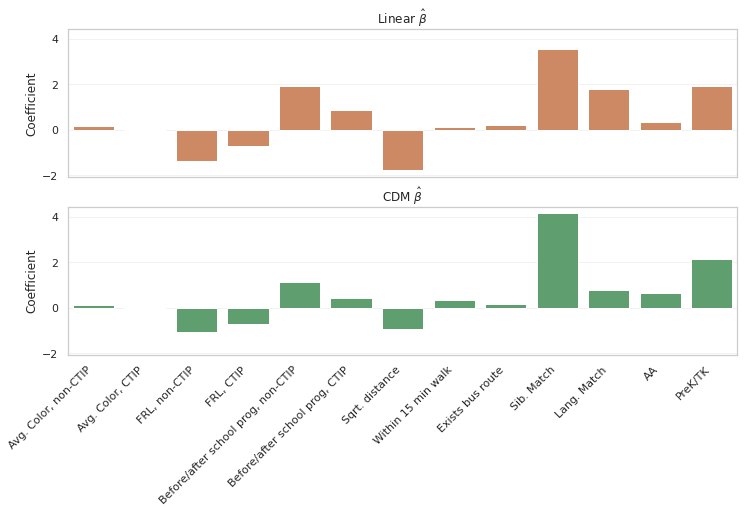

In [120]:
beta_linear = pd.concat([pd.DataFrame([beta.weight.detach().numpy().flatten(), covariate_names, np.full((len(covariate_names)), fill_value=i+1)]).transpose() for i, beta in enumerate(model_dict['linear'].beta)])
beta_linear.columns=['coefficient','covariate','k']
beta_cdm = pd.concat([pd.DataFrame([beta.weight.detach().numpy().flatten(), covariate_names, np.full((len(covariate_names)), fill_value=i+1)]).transpose() for i, beta in enumerate(model_dict['cdm'].beta)])
beta_cdm.columns=['coefficient','covariate','k']

fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True, sharey=True)
sns.barplot(data = beta_linear, x='covariate', y='coefficient', color=palette[2], ax=ax[0]).set(
        title=r'Linear $\hat{\beta}$',
        xlabel='',
        ylabel=r'Coefficient'
    )
sns.barplot(data = beta_cdm, x='covariate', y='coefficient', color=palette[3], ax=ax[1]).set(
        title=r'CDM $\hat{\beta}$',
        xlabel='',
        ylabel=r'Coefficient'
    )
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, fontdict={'horizontalalignment':'right'})
fig.savefig('../Figs/beta.pdf', format='pdf', bbox_inches='tight')

In [121]:
prog_mapping = pd.DataFrame({
    'program type': ['GE', 
                     'MM', 'MS', 'SA', 'AF', 'ED', 
                     'SN', 'SE', 'NS', 'SB',
                     'CE', 'CN', 'ME', 'MN', 'CT', 'NC', 'CB', 
                     'JN', 'JE', 
                     'KE', 'KN',
                     'DA', 'DT', 'FB'],
})
sort_mapping = prog_mapping.reset_index().set_index('program type')
program_attributes['program_num'] = program_attributes['program_type'].map(sort_mapping['index'])
program_attributes['logits'] = 0.0
program_attributes.loc[program_codex, 'logits'] = -pl_logits

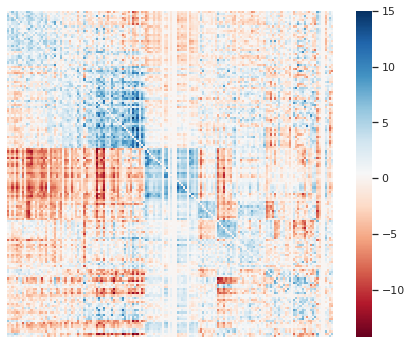

In [122]:
pl_logits = pd.Series(model_dict['fixed'].logits[0].weight.detach().numpy()[:-1].flatten(), index=program_codex)
pl_logits -= pl_logits.mean()

target = pd.DataFrame(model_dict['cdm'].target_embeddings[0].weight.detach().numpy()[:-1], index=program_codex)
context = pd.DataFrame(model_dict['cdm'].context_embeddings[0].weight.detach().numpy()[:-1], index=program_codex)
Ufull = target.values @ context.values.T
np.fill_diagonal(Ufull,0); Ufull -= Ufull.sum()/(num_programs*(num_programs-1)); np.fill_diagonal(Ufull,0)

Ufull_df = pd.DataFrame(Ufull, index=program_codex, columns=program_codex)
sorted_U_df = Ufull_df.loc[program_attributes.loc[program_codex].sort_values(by=['program_num', 'logits']).index, 
                           program_attributes.loc[program_codex].sort_values(by=['program_num', 'logits']).index]

fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.heatmap(data=sorted_U_df, cmap='RdBu', square=True, xticklabels=False, yticklabels=False, ax=ax).set(xlabel='', ylabel='')
fig.savefig('../Figs/U_col.pdf', format='pdf', bbox_inches='tight')

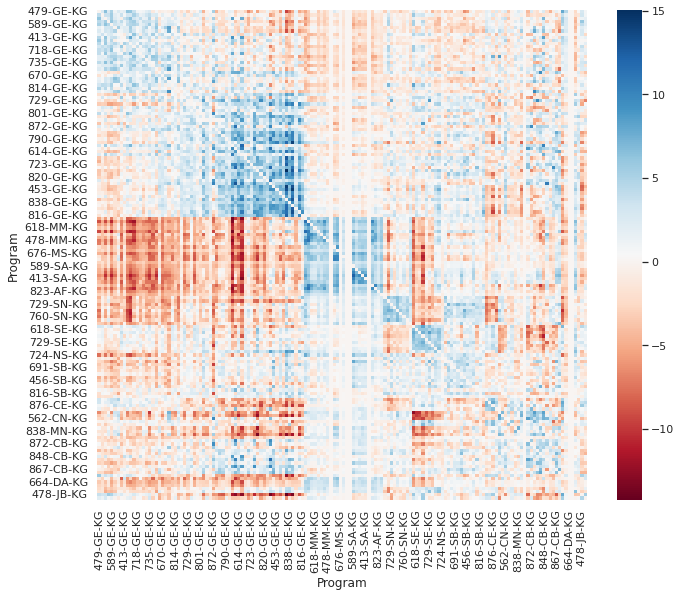

In [123]:
fig, ax = plt.subplots(1,1,figsize=(11,9))
sns.heatmap(data=sorted_U_df, cmap='RdBu', square=True, xticklabels='auto', yticklabels='auto', ax=ax).set(
    xlabel='Program', 
    ylabel='Program')
fig.savefig('../Figs/U.pdf', format='pdf', bbox_inches='tight')

# Sample preferences

In [ ]:
importlib.reload(sp)

In [ ]:
nest_memberships = program_attributes.loc[program_codex,'nest_id'].values
kwargs={'fixed_effects': True,
        'linear_terms': True,
        'covariates': X,
        'num_nests': len(nests),
        'nest_memberships': nest_memberships,
        'num_ranks': 0}
nested_model, _, _, _, _ = sp.train_stratified(ds=choices, 
                                               num_items=num_programs, 
                                               epochs=1000, 
                                               lr=1e-3, 
                                               wd=1e-5, 
                                               verbose=True, 
                                               Model=sp.Nested_MNL,
                                               **kwargs)
model_dict['nested'] = nested_model

In [212]:
generate_full_preferences(0, 'nested', model_dict['nested'], program_attributes_1819, student_codex_test, program_codex, ctip_codex_test, return_mode=False)

TypeError: '<=' not supported between instances of 'NoneType' and 'float'

Assertion failed: ok (src/mailbox.cpp:99)


In [182]:
generate_full_preferences(1, 'nested', model_dict['nested'], program_attributes_1819, student_codex_test, program_codex, ctip_codex_test, return_mode=False)

tensor([[[3.5000, 0.0000, 0.3672,  ..., 0.0000, 0.0000, 0.0000],
         [3.5000, 0.0000, 0.3672,  ..., 0.0000, 0.0000, 0.0000],
         [3.5000, 0.0000, 0.2960,  ..., 0.0000, 1.0000, 1.0000],
         ...,
         [4.5000, 0.0000, 0.2964,  ..., 0.0000, 0.0000, 0.0000],
         [4.5000, 0.0000, 0.2964,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[3.5000, 0.0000, 0.3672,  ..., 0.0000, 0.0000, 0.0000],
         [3.5000, 0.0000, 0.3672,  ..., 0.0000, 0.0000, 0.0000],
         [3.5000, 0.0000, 0.2960,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [4.5000, 0.0000, 0.2964,  ..., 0.0000, 0.0000, 0.0000],
         [4.5000, 0.0000, 0.2964,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  

RuntimeError: invalid multinomial distribution (sum of probabilities <= 0)

In [211]:
def generate_full_preferences(i, model_name, model, program_attributes, student_codex, program_codex, ctip_codex, return_mode=False):
    '''
    Generates preferences that are either sampled from the distribution or the modal selection 
    (highest probability alternative) at each rank position.
        - model is of StratifiedLinear class.
        - student_codex is in travel_times.index
        - program_codex is same as used for training
    '''
    random.seed(model_name+str(i))
    n_students = len(student_codex)
    n_programs = len(program_codex)
    preferences=t.zeros((n_students, n_programs),dtype=int)
    X_sample = generate_covariate_matrix(program_attributes, student_codex, program_codex, ctip_codex)

    if model is None:
        probs=t.ones((n_students, n_programs))/float(n_programs)
        preferences = t.multinomial(probs, num_samples=n_programs, replacement=False)
        return model_name, preferences
    
    elif model_name == 'nested':
        num_agents, num_alternatives, num_features = X_sample.shape
        pad_mat = np.zeros((num_agents, num_features), dtype=np.float32)
        X_sample = np.hstack([X_sample, pad_mat[:,None,:]]) # add zeros matrix to second dimension of covariates (column-wise)
        
        X_sample = t.from_numpy(X_sample)
        x = t.from_numpy(np.tile(np.arange(n_programs)[None,:], (n_students,1)))
        x_extra = t.from_numpy(np.arange(n_students))
        C = t.ones((n_students, n_programs))
        for i in range(n_programs):
            probs = model.compute_nested_probabilities(x, x_extra, C, X_sample, sampling=True)
            if t.any(t.all(probs<=0., dim=1)):
                print('Found all 0s row')
            selections = (probs).argmax(axis=1) if return_mode else t.multinomial(probs,num_samples=1)
            preferences[:,i] = selections.flatten()
            x[np.arange(n_students), selections] = n_programs
            C[np.arange(n_students), selections] = 0
        return model_name, preferences
    
    else:
        for i in range(model.k-1):
            utilities = t.zeros((n_students, n_programs))
            if model.fixed_effects:
                logits = model.logits[i].weight.detach().numpy()[:-1].flatten()
                utilities += logits[None,:]

            if model.linear_terms:
                linear = X_sample@model.beta[i].weight.detach().numpy().flatten()
                utilities += linear

            if (i>0) & model.context:
                T = model.target_embeddings[i].weight.detach().numpy()[:-1,:] # num_programs, embedding_dim
                C = model.context_embeddings[i](preferences[:,:i]).detach().numpy() # num_students, i, embedding_dim
                # avg_C = C.sum(axis=-2) # num_students, embedding_dim
                avg_C = C.mean(axis=-2) # num_students, embedding_dim
                avg_interactions = (avg_C @ T.T)
                utilities += avg_interactions
            utilities[np.arange(n_students)[:,None], preferences[:,:i]]=-np.inf
            softmax_probs = softmax(utilities, axis=1)
            preferences[:,i] = softmax_probs.argmax(axis=1) if return_mode else t.multinomial(softmax_probs, num_samples=1).flatten()

        utilities = t.zeros((n_students, n_programs))
        if model.fixed_effects:
            logits = model.logits[-1].weight.detach().numpy()[:-1].flatten()
            utilities += logits[None,:]

        if model.linear_terms:
            linear = X_sample@model.beta[-1].weight.detach().numpy().flatten()
            utilities += linear

        if model.context:
            T = model.target_embeddings[-1].weight.detach().numpy()[:-1,:] # num_programs, embedding_dim
            for i in range(model.k-1,n_programs):
                if i>0:
                    C = model.context_embeddings[-1](preferences[:,:i]).detach().numpy() # num_students, i, embedding_dim
                    avg_C = C.mean(axis=-2) # num_students, embedding_dim
                    avg_interactions = (avg_C @ T.T)
                    utilities += avg_interactions
                utilities[np.arange(n_students)[:,None], preferences[:,:i]] = -np.inf
                softmax_probs = softmax(utilities, axis=1)
                preferences[:,i] = softmax_probs.argmax(axis=1) if return_mode else t.multinomial(softmax_probs, num_samples=1).flatten()
        else:
            utilities[np.arange(n_students)[:,None], preferences[:,:(model.k-1)]] = -np.inf
            softmax_probs = softmax(utilities, axis=1)
            preferences[:,(model.k-1):] = (-softmax_probs).argsort(axis=1)[:,:(n_programs-(model.k-1))] if return_mode else t.multinomial(softmax_probs,num_samples=n_programs-(model.k-1),replacement=False)

        return model_name, preferences

In [170]:
num_samples=100
sample_results = Parallel(n_jobs=-4)(delayed(generate_full_preferences)(i, 
                                                                        model_name, 
                                                                        model_dict[model_name],
                                                                        program_attributes_1819,
                                                                        student_codex_test, 
                                                                        program_codex, 
                                                                        ctip_codex_test) 
                                     for i in range(num_samples) 
                                     for model_name in model_names[:-1])
sampled_preferences = {key: [] for key in model_dict.keys()}
[sampled_preferences[name].append(prefs) for name, prefs in sample_results]

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
  File "<frozen importlib._bootstrap_external>", line 153, in _path_is_mode_type
  File "<frozen importlib._bootstrap_external>", line 153, in _path_is_mode_type
Traceback (most recent call last):
Fatal Python error: init_import_siteTraceback (most recent call last):
:   File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
Failed to import the site module
Traceback (most recent call last):
Python runtime state: Traceback (most recent call last):
initialized
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
Traceback (most recent call last):
  File "<frozen importl

KeyboardInterrupt: 

In [345]:
stacked_sampled_prefs = {}
for key, value in sampled_preferences.items():
    if key=='nested':
        continue
    stacked_sampled_prefs[key]=np.dstack(value)

In [346]:
sampled_preferences_rank = {key: [array.argsort(axis=1) for array in sampled_preferences[key]] for key in model_names[:-1]}

# Evaluate samples

## Agreement at $k$

In [347]:
def generate_DA_inputs(dataset, stud_codex, codex, program_data, compute_travel_times=False):
    '''
    Must have 'ranked_schools_codex', and 'r1_randomnumber_adjusted' fields in the dataset.
    '''
    n=len(codex)
    assert(dataset.shape[0]==len(stud_codex))
    StudPrefs = np.full(fill_value=n, shape=(dataset.shape[0], n))
    StudentPrts = np.zeros((dataset.shape[0], n))
    for ind, row in dataset.iterrows():
        student_id = int(row['student_id'])
        programs = row['r1_ranked_programs'] if len(row['r1_ranked_programs'])!=0 else row['r2_ranked_programs'] if len(row['r2_ranked_programs'])!=0 else row['r3_ranked_programs'] if len(row['r3_ranked_programs'])!=0 else row['r4_ranked_programs'] if len(row['r4_ranked_programs'])!= 0 else row['r5_ranked_programs']
        StudPrefs[student_id, :len(programs)] = [codex.index(program) for program in programs]
        sibling, aaprek, aa = row['sibling'], row['aaprek'], row['idschoolattendance']
        sib_programs, aaprek_programs = [], []
        [sib_programs.extend(list(program_data[program_data.school_id==school].index.values)) for school in sibling]
        index_sibling = [codex.index(program) for program in sib_programs if program in codex]
        [aaprek_programs.extend(list(program_data[program_data.school_id==school].index.values)) for school in aaprek]
        index_aaprek = [codex.index(program) for program in aaprek_programs if program in codex]
        index_aa = [codex.index(program) for program in program_data[program_data.school_id==aa].index.values if program in codex]
        '''
        Encode priorities as follows:
        Sibling  +16
        AA Prek  +8
        CTIP1    +4
        AA       +2
        Tiebreak +random number
        '''
        StudentPrts[student_id, index_sibling] += 16.
        StudentPrts[student_id, index_aaprek] += 8.
        if row['ctip1']:
            StudentPrts[student_id] += 4.
        StudentPrts[student_id, index_aa] += 2.
    SchoolCaps = program_data.loc[codex, 'capacity'].values
    return SchoolCaps, StudentPrts, StudPrefs


In [469]:
df_test.shape[0]-subset_df_test.shape[0]

804

In [348]:
df_test['student_id']=[student_codex_test.index(studid) if studid in student_codex_test else None for studid in df_test['studentno']]
subset_df_test = df_test.dropna(subset=['student_id'])

/tmp/ipykernel_3497497/1481570219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['student_id']=[student_codex_test.index(studid) if studid in student_codex_test else None for studid in df_test['studentno']]


In [349]:
SchoolCaps_1819, StudentPrts_1819, StudPrefs_1819 = generate_DA_inputs(subset_df_test, student_codex_test, program_codex, program_attributes_1819)

In [350]:
def generate_one(i, model_name, model, program_attributes, student_codex, program_codex, ctip_codex, prefs, rank, return_mode=False):
    '''
    Generates rank-position choice given prior rank choices in prefs.
    '''
    random.seed(model_name+str(i))
    n_students = len(student_codex)
    n_programs = len(program_codex)
    
    preferences = copy.deepcopy(prefs)
    next_open_slot = np.argmax(preferences==n_programs, axis=1)
    assert(max(next_open_slot)<=rank)
    rows_to_sample = (next_open_slot==rank)
    
    if model_name=='null':
        probs = np.divide(np.ones((n_students, n_programs+1)), (preferences==n_programs).sum(1)[:,None])
        probs[np.arange(n_students)[:,None], preferences]=0.
        preferences[rows_to_sample, rank] = probs[rows_to_sample,:].argmax(axis=1) if return_mode else t.multinomial(t.Tensor(probs)[rows_to_sample,:], num_samples=1).flatten()
        return model_name, preferences
    else:
        k=model.k
        X_sample = generate_covariate_matrix(program_attributes, student_codex, program_codex, ctip_codex)

        utilities = t.zeros((n_students, n_programs))
        if model.fixed_effects:
            utilities[rows_to_sample] += model.logits[min(k-1, rank)].weight.detach().numpy()[:-1].flatten()[None,:]
        else: 
            pass
        if model.linear_terms:
            beta = model.beta[min(k-1, rank)].weight.detach().numpy().flatten()
            utilities[rows_to_sample]+=X_sample[rows_to_sample]@beta #n_stud x n_prog
        else: 
            pass
        if (rank>0) & model.context:
            T = model.target_embeddings[min(k-1, rank)].weight.detach().numpy()[:-1,:] # num_programs, embedding_dim
            C = model.context_embeddings[min(k-1, rank)](preferences[rows_to_sample,:rank]).detach().numpy() # num_students, rank, embedding_dim
            avg_C = C.mean(axis=-2) # num_students, embedding_dim
            avg_interactions = (avg_C @ T.T)
            utilities[rows_to_sample] += avg_interactions
        else:
            pass
        utilities = np.concatenate((utilities, np.full((n_students, 1), fill_value=-np.inf)), axis=1)
        utilities[np.arange(n_students)[:,None], preferences[:,:rank]]=-np.inf
        viable_softmax_probs = softmax(utilities[rows_to_sample], axis=1)
        preferences[rows_to_sample,rank] = viable_softmax_probs.argmax(axis=1) if return_mode else t.multinomial(t.Tensor(viable_softmax_probs), num_samples=1).flatten()
        return model_name, preferences



In [351]:
num_samples=100
input_prefs = np.full((len(student_codex_test), num_programs), fill_value=num_programs)
modal_results = {rank: [] for rank in range(10)}
sample_results = {rank: [] for rank in range(10)}
for rank in tqdm(range(10)):
    input_prefs[:,:rank] = StudPrefs_1819[:,:rank]
    sample_results[rank]=Parallel(n_jobs=-4)(delayed(generate_one)(k, model_name, model_dict[model_name], program_attributes_1819, student_codex_test, program_codex, 
                                                                  ctip_codex_test, input_prefs, rank) 
                                            for model_name in model_names[:-1]
                                            for k in range(num_samples))
    modal_results[rank]=Parallel(n_jobs=-4)(delayed(generate_one)(0, model_name, model_dict[model_name], program_attributes_1819, student_codex_test, program_codex, 
                                                                  ctip_codex_test, input_prefs, rank, return_mode=True) 
                                                 for model_name in model_names[:-1])

100%|██████████| 10/10 [12:49<00:00, 76.91s/it]


In [352]:
results_modal = {i: {model: [] for model in model_names[:-1]} for i in range(10)}
results_sample = {i: {model: [] for model in model_names[:-1]} for i in range(10)}
for i in range(10):
    [results_modal[i][name].append(pref) for name, pref in modal_results[i]]
    [results_sample[i][name].append(pref) for name, pref in sample_results[i]]

In [353]:
def agreement(rank, model_name, array):
    inds = (array[:, rank]!=num_programs) & (StudPrefs_1819[:, rank]!=num_programs)
    return rank, model_name, (array[inds,rank]==StudPrefs_1819[inds,rank]).mean(), sum(inds)

agreement_results=Parallel(n_jobs=-4)(delayed(agreement)(rank, model_name, array)
                                        for rank in range(10) 
                                        for model_name in model_names[:-1] 
                                        for array in results_modal[rank][model_name])
modal_agreements=pd.DataFrame(agreement_results, columns=['rank position', 'model name', 'agreement w true', 'no. eligible ballots'])

In [354]:
modal_agreements[['model', 'stratified']] = [[name.split()[-1], 'strat' in name] for name in modal_agreements['model name']]

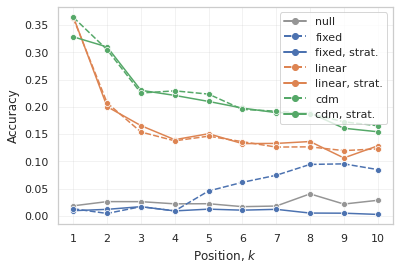

In [391]:
custom_lines = [Line2D([0], [0], color=palette[0], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[1], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[1], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[2], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[2], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='-', marker='o', lw=2)]
fig, ax=plt.subplots(1,1)
sns.lineplot(data=modal_agreements, x='rank position', y='agreement w true', hue='model', style='stratified', palette=palette[:-1], marker='o', ax=ax)
ax.set_xticks(np.arange(10), np.arange(10)+1)
# ax.legend()
ax.legend(custom_lines, ['null', 
                         'fixed', 'fixed, strat.', 
                         'linear', 'linear, strat.', 
                         'cdm', 'cdm, strat.'], loc='upper right')
ax.set_ylabel('Accuracy')
ax.set_xlabel(r'Position, $k$')
fig.savefig('../Figs/accuracy_at_k.pdf', format='pdf')

### By subpopulation

In [357]:
school_codex = program_attributes_1819.loc[program_codex, 'school_id'].unique()

In [358]:
reindexed_df = subset_df_test.set_index('studentno').loc[student_codex_test]
reindexed_df['top_ranked_prog'] = 0
for ind, row in reindexed_df.iterrows():
    round_idx = row['first_participated_round']
    programs = row['r'+str(round_idx)+'_programs']
    reindexed_df.loc[ind, 'top_ranked_prog'] = programs[0]
those_who_ranked_lang_first = reindexed_df['top_ranked_prog'].isin(program_to_language.keys())
those_with_siblings = (reindexed_df['sibling'].str.len()!=0).values
those_with_aaprek = (reindexed_df['aaprek'].str.len()!=0).values
those_with_aa = (~reindexed_df['idschoolattendance'].isna()).values
print('AA:\t\t', those_with_aa.mean())
print('Lang First:\t', those_who_ranked_lang_first.mean())
print('Sibling:\t', those_with_siblings.mean())
print('CTIP1:\t\t', np.array(ctip_codex).mean())
print('AAPrek:\t\t', those_with_aaprek.mean())

AA:		 1.0
Lang First:	 0.336150234741784
Sibling:	 0.3002347417840376
CTIP1:		 0.16676628810520025
AAPrek:		 0.034976525821596244


In [359]:
first_sibling = []
first_aaprek = []
first_aa = []
for _, row in reindexed_df.iterrows():
    sibling_schools = row['sibling']
    aaprek_schools = row['aaprek']
    aa_school = row['idschoolattendance']
    first_round = str(row['first_participated_round'])
    ranked_schools = row['r'+first_round+'_ranked_idschool']
    sibling_rank = np.where([school in sibling_schools for school in ranked_schools])[0]
    aaprek_rank = np.where([school in aaprek_schools for school in ranked_schools])[0]
    aa_rank = np.where([school==aa_school for school in ranked_schools])[0]
    if sibling_rank.size>0:
        first_sibling.append(sibling_rank[0])
    if aaprek_rank.size>0:
        first_aaprek.append(aaprek_rank[0])
    if aa_rank.size>0:
        first_aa.append(aa_rank[0])

In [360]:
no_aa = np.full(len(student_codex_test), fill_value=False)
for _, row in reindexed_df.iterrows():
    student = row['student_id']
    aa_school = row['idschoolattendance']
    first_round = str(row['first_participated_round'])
    ranked_schools = row['r'+first_round+'_ranked_idschool']
    aa_rank = np.where([school==aa_school for school in ranked_schools])[0]
    if aa_rank.size==0:
        no_aa[int(student)]=True

In [361]:
reindexed_df['ranked AA'] = ~no_aa
reindexed_df['has sibling'] = those_with_siblings

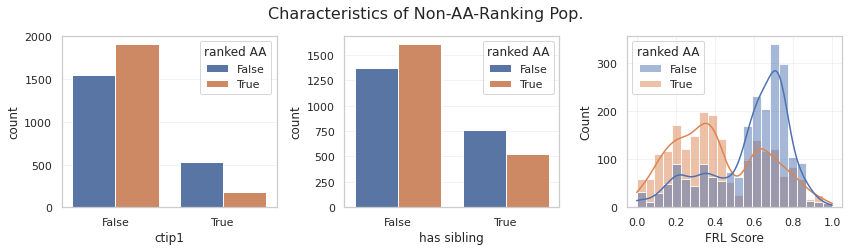

In [362]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

# distribution of ctip
sns.countplot(data=reindexed_df, x='ctip1', hue='ranked AA', ax=ax[0])
ax[0].set_xticklabels(labels=[False, True])

# distribution of siblings
sns.countplot(data=reindexed_df, x='has sibling', hue='ranked AA', ax=ax[1])

# distribution of SES
sns.histplot(data=reindexed_df, x='FRL Score', hue='ranked AA', kde=True, ax=ax[2])

plt.suptitle('Characteristics of Non-AA-Ranking Pop.', size=16, x=0.5, y=0.9)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

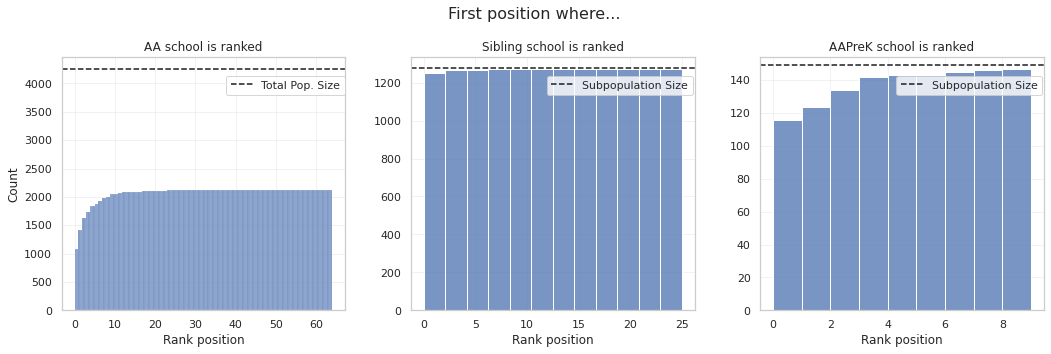

In [363]:
fig,ax=plt.subplots(1,3,figsize=(15,5))
fig.suptitle('First position where...', size=16)
sns.histplot(first_aa, cumulative=True, ax=ax[0])
ax[0].axhline(those_with_aa.sum(), color='k', linestyle='--', label='Total Pop. Size')
ax[0].set_xlabel('Rank position')
ax[0].set_ylabel('Count')
ax[0].set_title(r'AA school is ranked')
ax[0].legend(loc=(0.58, 0.85))
sns.histplot(first_sibling, cumulative=True, ax=ax[1])
ax[1].axhline(those_with_siblings.sum(), color='k', linestyle='--', label='Subpopulation Size')
ax[1].set_xlabel('Rank position')
ax[1].set_ylabel('')
ax[1].set_title(r'Sibling school is ranked')
ax[1].legend(loc=(0.48, 0.85))
sns.histplot(first_aaprek, cumulative=True, ax=ax[2])
ax[2].axhline(those_with_aaprek.sum(), color='k', linestyle='--', label='Subpopulation Size')
ax[2].set_title(r'AAPreK school is ranked')
ax[2].set_xlabel('Rank position')
ax[2].set_ylabel('')
ax[2].legend(loc=(0.48, 0.85))
plt.tight_layout()

In [364]:
def agreement(rank, model_name, array, level='program', subpop=None, subset=None):
    if subset is None:
        subset=np.full(StudPrefs_1819.shape[0], fill_value=True)
    inds = subset & (array[:, rank]!=num_programs) & (StudPrefs_1819[:, rank]!=num_programs)
    if level=='program':
        result = (array[inds,rank]==StudPrefs_1819[inds,rank]).mean()
    elif level=='school':
        modal_programs = array[inds,rank]
        modal_schools = program_attributes_1819.loc[np.array(program_codex)[modal_programs], 'school_id']
        true_programs = StudPrefs_1819[inds,rank]
        true_schools = program_attributes_1819.loc[np.array(program_codex)[true_programs], 'school_id']
        result = (modal_schools.values==true_schools.values).mean()
    else:
        return None
    return rank, model_name, level, subpop, result, sum(inds)

In [365]:
subpop_agreement_results=Parallel(n_jobs=-4)(delayed(agreement)(rank, model_name, array, level, subpop, subset)
                                             for model_name in model_names[:-1]
                                             for rank in [0,1,2]
                                             for level in ['program', 'school']
                                             for array in results_modal[rank][model_name]
                                             for subpop, subset in [('aa', those_with_aa),
                                                                    ('language_first', those_who_ranked_lang_first),
                                                                    ('sibling', those_with_siblings),
                                                                    ('ctip1', ctip_codex_test), 
                                                                    ('aaprek', those_with_aaprek),
                                                                    ('Asian', (reindexed_df.resolved_ethnicity=='Asian').values),
                                                                    ('Hispanic/Latino', (reindexed_df.resolved_ethnicity=='Hispanic/Latino').values),
                                                                    ('Decline to State', (reindexed_df.resolved_ethnicity=='Decline to State').values),
                                                                    ('White', (reindexed_df.resolved_ethnicity=='White').values),
                                                                    ('Two or More Races', (reindexed_df.resolved_ethnicity=='Two or More Races').values),
                                                                    ('Black or African American', (reindexed_df.resolved_ethnicity=='Black or African American').values)])
subpop_modal_agreements = pd.DataFrame(subpop_agreement_results, columns=['rank position', 'model name', 'level', 'subpopulation', 'accuracy', 'no. eligible ballots'])

In [366]:
subpop_modal_agreements[['model', 'stratified']] = [[name.split()[-1], 'strat' in name] for name in subpop_modal_agreements['model name']]

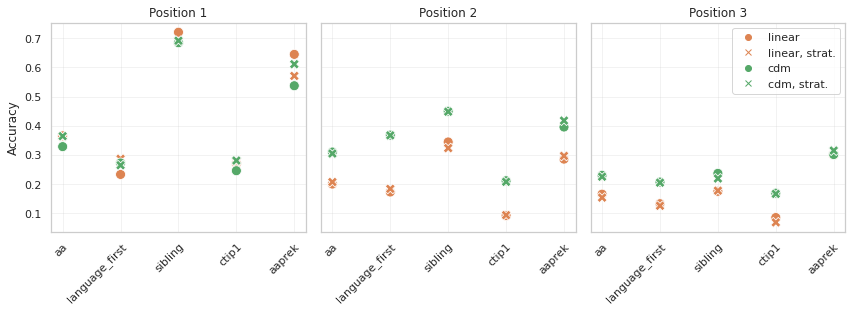

In [461]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(12,4.5))
data = subpop_modal_agreements[(subpop_modal_agreements.model.isin(['linear', 'cdm'])) & (subpop_modal_agreements.level=='program') & (~subpop_modal_agreements.subpopulation.isin(['Asian', 'Hispanic/Latino', 'Decline to State', 'White', 'Two or More Races', 'Black or African American']))]
sns.scatterplot(data=data[data['rank position']==0], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:4], s=100, ax=ax[0])
sns.scatterplot(data=data[data['rank position']==1], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:4], s=100, ax=ax[1])
sns.scatterplot(data=data[data['rank position']==2], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:4], s=100, ax=ax[2])
ax[0].set_title('Position 1')
ax[1].set_title('Position 2')
ax[2].set_title('Position 3')
ax[0].set_ylabel('Accuracy')
for i in range(3):
    ax[i].legend().remove()
    ax[i].set_xlabel('')
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
custom_points = [Line2D([0], [0], marker='o', color=palette[2], lw=0), 
                 Line2D([0], [0], marker='x', color=palette[2], lw=0), 
                 Line2D([0], [0], marker='o', color=palette[3], lw=0), 
                 Line2D([0], [0], marker='x', color=palette[3], lw=0)]
ax[2].legend(custom_points, ['linear', 'linear, strat.', 'cdm', 'cdm, strat.'])
plt.tight_layout()
fig.savefig('../Figs/by_subpopulation_priority.pdf', format='pdf')


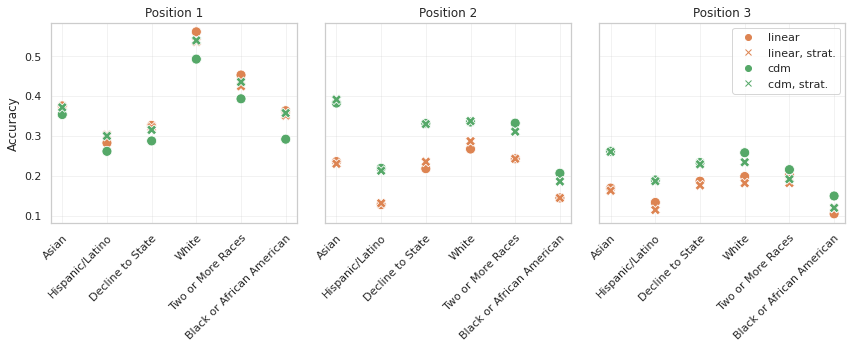

In [462]:
fig, ax = plt.subplots(1,3,sharey=True,figsize=(12,5))
data = subpop_modal_agreements[(subpop_modal_agreements.model.isin(['linear', 'cdm'])) & (subpop_modal_agreements.level=='program') & (subpop_modal_agreements.subpopulation.isin(['Asian', 'Hispanic/Latino', 'Decline to State', 'White', 'Two or More Races', 'Black or African American']))]
sns.scatterplot(data=data[data['rank position']==0], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:4], s=100, ax=ax[0])
sns.scatterplot(data=data[data['rank position']==1], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:4], s=100, ax=ax[1])
sns.scatterplot(data=data[data['rank position']==2], x='subpopulation', y='accuracy', hue='model', style='stratified', palette=palette[2:4], s=100, ax=ax[2])
ax[0].set_title('Position 1')
ax[1].set_title('Position 2')
ax[2].set_title('Position 3')
ax[0].set_ylabel('Accuracy')
for i in range(3):
    ax[i].legend().remove()
    ax[i].set_xlabel('')
    plt.setp(ax[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", visible=True)
custom_points = [Line2D([0], [0], marker='o', color=palette[2], lw=0), 
                 Line2D([0], [0], marker='x', color=palette[2], lw=0), 
                 Line2D([0], [0], marker='o', color=palette[3], lw=0), 
                 Line2D([0], [0], marker='x', color=palette[3], lw=0)]
ax[2].legend(custom_points, ['linear', 'linear, strat.', 'cdm', 'cdm, strat.'])
plt.tight_layout()
fig.savefig('../Figs/by_subpopulation_demo.pdf', format='pdf')


## Agreement in Top $k$

In [ ]:
def agreement_in_top_k(k, model_name, sampled_prefs, true_prefs, n):
    '''
    k: integer
    sampled_prefs: num_students x num_alternatives x num_samples array. 
        each row is an ordered array of program-ids.
    true_prefs: num_students x num_alternatives array.
    '''        
    list_lengths = (true_prefs==n).argmax(axis=1)
    eligible_students = list_lengths>=k
    
    true_top_k = true_prefs[eligible_students,:k]
    sampled_top_k = sampled_prefs[eligible_students, :k, :]
    
    agreements=[]
    for true, sim in zip(true_top_k, sampled_top_k):
        values, counts = np.unique(sim, return_counts=True)
        tuples = list(zip(values, counts))
        tuples.sort(key = lambda x: -x[1])
        sim_top_k = [prog for prog, count in tuples[:k]]
        intersection = set(true).intersection(set(sim_top_k))
        agreements.append(len(intersection))
    
    return (model_name, 'strat' in model_name, k, sum(agreements)/(sum(eligible_students)*float(k)))

In [ ]:
agreement_results=Parallel(n_jobs=-4)(delayed(agreement_in_top_k)(k, model_name, stacked_sampled_prefs[model_name], StudPrefs_1819, num_programs)
                                        for k in range(1,11) 
                                        for model_name in model_dict.keys())
sampled_agreement_df = pd.DataFrame(agreement_results, columns=['model name', 'stratified', 'k', '% agreement'])
agreement_results=Parallel(n_jobs=-4)(delayed(agreement_in_top_k)(k, model_name, stacked_modal_prefs[model_name], StudPrefs_1819, num_programs)
                                        for k in range(1,11) 
                                        for model_name in model_dict.keys())
modal_agreement_df = pd.DataFrame(agreement_results, columns=['model name', 'stratified', 'k', '% agreement'])

In [ ]:
sampled_agreement_df['model'] = [name.split()[-1] for name in sampled_agreement_df['model name']]
modal_agreement_df['model'] = [name.split()[-1] for name in modal_agreement_df['model name']]

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(6,5))
sns.lineplot(data=sampled_agreement_df, x='k', y='% agreement', hue='model', style='stratified', palette=palette, marker='o', ax=ax)
ax.set_ylabel('Agreement')
ax.set_xlabel(r'$k$')
ax.set_xticks(np.arange(1,11), np.arange(10)+1)
ax.legend(loc=(1.05,0.3))
plt.title('% Agreement in Top K', fontsize=16)

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(6,5))
sns.lineplot(data=modal_agreement_df, x='k', y='% agreement', hue='model', style='stratified', palette=palette, marker='o', ax=ax)
ax.set_ylabel('Agreement')
ax.set_xlabel(r'$k$')
ax.set_xticks(np.arange(1,11), np.arange(10)+1)
ax.legend(loc=(1.05,0.3))
plt.title('Agreement in Top-$k$', fontsize=16)

## Correct in pairs

In [ ]:
def pairwise_correct(true_pref, ranks, m):
    '''
    true_pref: m-length vector of student's true preferences. padded with 'm'
    simulated_pref: m-length vector of sampled preferences
    
    output: float, fraction of pairwise comparisons correct by simulated pref
    '''
    ranked_list = true_pref[true_pref!=m]

    correct = []
    counter = 0
    for i, elem1 in enumerate(ranked_list):
        for j, elem2 in enumerate(ranked_list[(i+1):]):
            correct.append(ranks[elem1]<ranks[elem2])
            counter+=1
    return sum(correct)/float(counter)

def pairwise_correct_full_data(model_name, true_prefs, ranks, m):
    list_lengths = (true_prefs==m).argmax(axis=1)
    eligible = list_lengths>1
    
    result=[]
    counter = 0
    for i, true_pref in enumerate(true_prefs):
        if eligible[i]:
            correct = np.apply_along_axis(lambda x: pairwise_correct(true_pref, x, m), 0, ranks[i,:,:])
            result.append(correct.mean())
            counter += 1
        else: 
            continue
    return (model_name, 'strat' in model_name, sum(result)/float(counter))
    # return (model_name, 'strat' in model_name, sum(result)/float(num_eligible))

In [ ]:
pairwise_results=Parallel(n_jobs=-4)(delayed(pairwise_correct_full_data)(model_name, StudPrefs, np.dstack(sampled_preferences_rank[model_name]), num_programs)
                                        for model_name in model_dict.keys())
sampled_pairwise_df = pd.DataFrame(pairwise_results, columns=['model name', 'stratified', '% correct in pairwise'])
pairwise_results=Parallel(n_jobs=-4)(delayed(pairwise_correct_full_data)(model_name, StudPrefs, np.dstack(modal_preferences_rank[model_name]), num_programs)
                                        for model_name in model_dict.keys())
modal_pairwise_df = pd.DataFrame(pairwise_results, columns=['model name', 'stratified', '% correct in pairwise'])

In [ ]:
sampled_pairwise_df['model'] = [name.split()[-1] for name in sampled_pairwise_df['model name']]
modal_pairwise_df['model'] = [name.split()[-1] for name in modal_pairwise_df['model name']]

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(6,5))
sns.scatterplot(data=sampled_pairwise_df, x='model name', y='% correct in pairwise', hue='model', palette=palette, s=150, ax=ax)
ax.set_ylabel(r'Agreement')
ax.tick_params(axis='x', labelrotation=90)
ax.legend().remove()
plt.title('Fraction Agreement in Pairs', fontsize=16)

In [ ]:
fig, ax=plt.subplots(1,1,figsize=(6,5))
sns.scatterplot(data=modal_pairwise_df, x='model name', y='% correct in pairwise', hue='model', palette=palette, s=150, ax=ax)
ax.set_ylabel(r'Agreement')
ax.tick_params(axis='x', labelrotation=90)
ax.legend().remove()
plt.title('Fraction Agreement in Pairs', fontsize=16)

## Correlations

In [384]:
def kendall_tau_wrapper(model1, model2, array1, array2, num_rows):
    rows_id = random.sample(range(array1.shape[0]), num_rows)
    corr_list=[]
    for row in rows_id:
        corr_list.append(weightedtau(array1[row], array2[row])[0])
    return model1, model2, corr_list

In [ ]:
num_rows_to_sample = 1000
result = Parallel(n_jobs=-4)(delayed(kendall_tau_wrapper)(model1, model2, sampled_preferences_rank[model1][k], sampled_preferences_rank[model2][k+1], num_rows_to_sample)
                             for model1, model2 in itertools.combinations_with_replacement(sampled_preferences_rank.keys(), r=2)
                             for k in range(num_samples-1))

In [ ]:
weighted_kt_df = pd.DataFrame(0, index=sampled_preferences_rank.keys(), columns=sampled_preferences_rank.keys())
for model1, model2, corr_list in result:
    total = np.array(corr_list).sum()
    weighted_kt_df.loc[model2, model1] += total
weighted_kt_matrix = (weighted_kt_df / (num_rows_to_sample * (num_samples-1))).values

/tmp/ipykernel_3497497/4248551503.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(weighted_kt_matrix, dtype=np.bool)


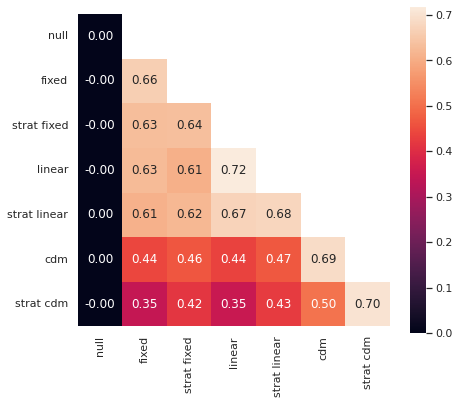

In [389]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
mask = np.zeros_like(weighted_kt_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, False)
sns.heatmap(weighted_kt_matrix, 
            xticklabels=model_names[:-1], 
            yticklabels=model_names[:-1], 
            mask=mask, 
            square=True,
            annot=True,
            fmt='.2f', ax=ax)
fig.savefig('../Figs/correlations.pdf', format='pdf')

## Consistency at $k$

In [390]:
def consistency(rank, model_name, arr1, arr2):
    inds = (arr1[:, rank]!=num_programs) & (arr2[:, rank]!=num_programs)
    return rank, model_name, (arr1[inds,rank]==arr2[inds,rank]).mean(), sum(inds)
consistency_results=Parallel(n_jobs=-4)(delayed(consistency)(rank, model_name, arr1, arr2)
                                        for rank in range(10) 
                                        for model_name in model_names[:-1]
                                        for arr1, arr2 in itertools.combinations(results_sample[rank][model_name], r=2))
consistencies=pd.DataFrame(consistency_results, columns=['rank position', 'model name', 'consistency', 'no. eligible ballots'])
consistencies[['model', 'stratified']] = [[name.split()[-1], 'strat' in name] for name in consistencies['model name']]

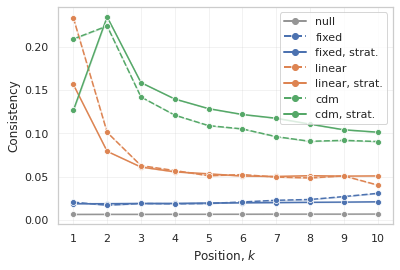

In [392]:
custom_lines = [Line2D([0], [0], color=palette[0], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[1], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[1], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[2], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[2], linestyle='-', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='--', marker='o', lw=2),
                Line2D([0], [0], color=palette[3], linestyle='-', marker='o', lw=2)]
fig, ax=plt.subplots(1,1)
sns.lineplot(data=consistencies, x='rank position', y='consistency', hue='model', style='stratified', 
             palette=palette[:-1], marker='o', ax=ax)
ax.set_xticks(np.arange(10), np.arange(10)+1)
ax.set_ylabel('Consistency')
ax.set_xlabel(r'Position, $k$')
ax.legend(custom_lines, ['null', 
                         'fixed', 'fixed, strat.', 
                         'linear', 'linear, strat.', 
                         'cdm', 'cdm, strat.'], loc='upper right')
fig.savefig('../Figs/consistencies.pdf', format='pdf')